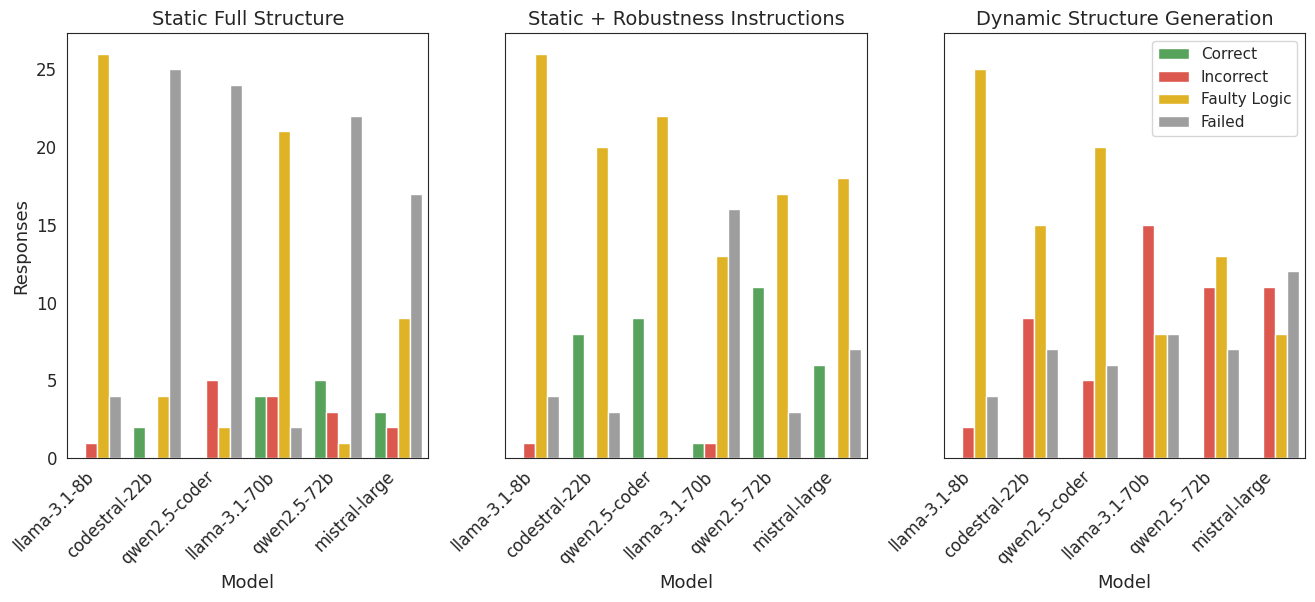

In [20]:
%pip install seaborn
%pip install jinja2
%pip install plotly
%pip install nbformat

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sns.set_style("white")

custom_order = [
    "llama-3.1-8b",
    "codestral-22b",
    "qwen2.5-coder",
    "llama-3.1-70b",
    "qwen2.5-72b",
    "mistral-large"
]

# Groupings
small_models = ["llama-3.1-8b", "codestral-22b", "qwen2.5-coder"]
large_models = ["llama-3.1-70b", "qwen2.5-72b", "mistral-large"]
model_groups = [small_models, large_models]

# Mapping of full model names to display labels
model_labels = {
    "meta-llama-3.1-8b-instruct": "llama-3.1-8b",
    "meta-llama-3.1-70b-instruct": "llama-3.1-70b",
    "mistral-large-instruct": "mistral-large",
    "qwen2.5-coder-32b-instruct": "qwen2.5-coder",
    "qwen2.5-72b-instruct": "qwen2.5-72b",
    "codestral-22b": "codestral-22b" 
}

#  F1 classifier
def classify_f1(row):
    if pd.isna(row["F1"]):
        return "Failed"
    elif row["F1"] == 1.0:
        return "Completely Correct"
    elif row["F1"] > 0:
        return "Partially Correct"
    else:
        return "Incorrect"

# Consistent colors
color_map = {
    "Completely Correct": "#4CAF50", 
    "Partially Correct": "#FFC107",
    "Incorrect": "#F44336",
    "Failed": "#B0B0B0" 
}

f1_order = ["Failed", "Incorrect", "Partially Correct", "Completely Correct"]

experiment_dirs = ["First Experiment", "Second Experiment", "Third Experiment"]
experiment_titles = ["Static Full Structure", "Static + Robustness Instructions", "Dynamic Structure Generation"]
dataframes = []

def classify_no_data_row(f1_processed, f1_nodata):
    def clamp01(x):
        if pd.isna(x): return x
        return max(0.0, min(1.0, float(x)))

    f1_p = clamp01(f1_processed)
    f1_n = clamp01(f1_nodata)

    # Failed: rerun on data produced no F1
    if pd.isna(f1_n):
        return "Failed"

    # Correct: processed==1 and produced a positive F1 on data (0,1]
    if f1_p == 1.0 and (0.0 < f1_n <= 1.0):
        return "Correct"

    # Faulty Logic: claimed perfect success on no-data, but failed on real data
    if f1_p == 1.0 and f1_n == 0.0:
        return "Faulty Logic"

    # Incorrect — No-Data Failure: cannot handle missing data at all
    if f1_p == 0.0 and f1_n >= 0.0:
        return "Incorrect"

    # Should not happen, but fallback
    return "Incorrect"

f1_order = ["Correct", "Incorrect", "Faulty Logic", "Failed"]

color_map = {
    "Correct": "#4CAF50",
    "Incorrect": "#F44336",
    "Faulty Logic": "#FFC107",
    "Failed": "#9E9E9E",
}

all_counts = []

for dir_label, title in zip(experiment_dirs, experiment_titles):
    nd_path = f"{dir_label}/nodata_results.csv"
    pr_path = f"{dir_label}/processed_result_evaluation_log.csv"

    df_nd = pd.read_csv(nd_path, na_values=["", " "])
    df_pr = pd.read_csv(pr_path, na_values=["", " "])

    df_nd["F1"] = pd.to_numeric(df_nd.get("F1"), errors="coerce")
    df_pr["F1"] = pd.to_numeric(df_pr.get("F1"), errors="coerce")

    join_cols = ["Experiment ID", "F1"]
    if "Experiment ID" not in df_nd.columns or "Experiment ID" not in df_pr.columns:
        raise KeyError("`Experiment ID` must exist in both nodata_results.csv and processed_result_evaluation_log.csv")

    merged = df_nd.merge(
        df_pr[join_cols].rename(columns={"F1": "F1_processed"}),
        on="Experiment ID",
        how="left",
    ).rename(columns={"F1": "F1_nodata"})

    if "Model" not in merged.columns:
        raise KeyError("`Model` column is required in nodata_results.csv")
    merged["Model"] = merged["Model"].map(model_labels).fillna(merged["Model"])

    merged["No-Data Outcome"] = merged.apply(
        lambda r: classify_no_data_row(r["F1_processed"], r["F1_nodata"]),
        axis=1
    )

    counts = (
        merged.groupby(["Model", "No-Data Outcome"])
        .size()
        .reset_index(name="Count")
    )
    counts["Experiment"] = title 
    all_counts.append(counts)
    
outcome_df = pd.concat(all_counts, ignore_index=True)
outcome_df["Model"] = pd.Categorical(outcome_df["Model"], categories=custom_order, ordered=True)
outcome_df["No-Data Outcome"] = pd.Categorical(outcome_df["No-Data Outcome"], categories=f1_order, ordered=True)

fig, axes = plt.subplots(1, len(experiment_titles), figsize=(13.3, 6.8), sharey=True)

for i, title in enumerate(experiment_titles):
    subset = outcome_df[outcome_df["Experiment"] == title]
    sns.barplot(
        data=subset,
        x="Model",
        y="Count",
        hue="No-Data Outcome",
        hue_order=f1_order,
        palette=color_map,
        ax=axes[i]
    )
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel("Model", fontsize=13)
    axes[i].set_ylabel("Responses" if i == 0 else "", fontsize=13)
    axes[i].tick_params(axis='x', rotation=45, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    if i == len(experiment_titles) - 1:
        axes[i].legend(loc="upper right", frameon=True, fontsize=11, title_fontsize=12)
    else:
        axes[i].legend_.remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
#plt.savefig("Images/Response Outcome Distribution per Model - No Data.png", dpi=600, bbox_inches='tight')
plt.show()

In [22]:
import pandas as pd
from IPython.display import display

bucket_cols = ["Correct", "Incorrect", "Faulty Logic", "Failed"]

def clamp01(x):
    if pd.isna(x):
        return x
    return max(0.0, min(1.0, float(x)))

all_rows = []
for dir_label, title in zip(experiment_dirs, experiment_titles):
    nd_path = f"{dir_label}/nodata_results.csv"
    pr_path = f"{dir_label}/processed_result_evaluation_log.csv"

    df_nd = pd.read_csv(nd_path, na_values=["", " "])
    df_pr = pd.read_csv(pr_path, na_values=["", " "])

    df_nd["F1"] = pd.to_numeric(df_nd.get("F1"), errors="coerce")
    df_pr["F1"] = pd.to_numeric(df_pr.get("F1"), errors="coerce")

    if "Experiment ID" not in df_nd.columns or "Experiment ID" not in df_pr.columns:
        raise KeyError("`Experiment ID` must exist in both nodata_results.csv and processed_result_evaluation_log.csv")

    merged = df_nd.merge(
        df_pr[["Experiment ID", "F1"]].rename(columns={"F1": "F1_processed"}),
        on="Experiment ID",
        how="left"
    ).rename(columns={"F1": "F1_nodata"})

    merged["Model"] = merged["Model"].map(model_labels).fillna(merged["Model"])
    merged["Experiment"] = title

    merged["Bucket"] = merged.apply(lambda r: classify_no_data_row(r["F1_processed"], r["F1_nodata"]), axis=1)

    all_rows.append(merged[["Experiment", "Model", "Bucket"]])

df_4 = pd.concat(all_rows, ignore_index=True)

df_4["Model"] = pd.Categorical(df_4["Model"], categories=custom_order, ordered=True)
df_4["Experiment"] = pd.Categorical(df_4["Experiment"], categories=experiment_titles, ordered=True)

counts_exp = (
    df_4.groupby(["Experiment", "Model", "Bucket"])
        .size()
        .unstack(fill_value=0)
)

for col in bucket_cols:
    if col not in counts_exp.columns:
        counts_exp[col] = 0

counts_exp = counts_exp[bucket_cols]

counts_exp["Total"] = counts_exp[bucket_cols].sum(axis=1)

pct_exp = counts_exp.copy()
totals_nonzero = counts_exp["Total"].replace({0: pd.NA})
for col in bucket_cols:
    pct_exp[col] = ((counts_exp[col] / totals_nonzero) * 100).round(1).fillna(0.0)

for exp in experiment_titles:
    print(f"No-Data Handling — Percentages by Model — {exp}")
    if exp in pct_exp.index.get_level_values(0):
        df_show = pct_exp.loc[exp].reset_index()
        # enforce model order in display
        df_show = df_show.set_index("Model").reindex(custom_order).reset_index()
        display(df_show[["Model"] + bucket_cols + ["Total"]])
    else:
        template = pd.DataFrame(0.0, index=custom_order, columns=bucket_cols + ["Total"]).reset_index().rename(columns={"index":"Model"})
        display(template)

No-Data Handling — Percentages by Model — Static Full Structure


Bucket,Model,Correct,Incorrect,Faulty Logic,Failed,Total
0,llama-3.1-8b,0.0,3.2,83.9,12.9,31
1,codestral-22b,6.5,0.0,12.9,80.6,31
2,qwen2.5-coder,0.0,16.1,6.5,77.4,31
3,llama-3.1-70b,12.9,12.9,67.7,6.5,31
4,qwen2.5-72b,16.1,9.7,3.2,71.0,31
5,mistral-large,9.7,6.5,29.0,54.8,31


No-Data Handling — Percentages by Model — Static + Robustness Instructions


Bucket,Model,Correct,Incorrect,Faulty Logic,Failed,Total
0,llama-3.1-8b,0.0,3.2,83.9,12.9,31
1,codestral-22b,25.8,0.0,64.5,9.7,31
2,qwen2.5-coder,29.0,0.0,71.0,0.0,31
3,llama-3.1-70b,3.2,3.2,41.9,51.6,31
4,qwen2.5-72b,35.5,0.0,54.8,9.7,31
5,mistral-large,19.4,0.0,58.1,22.6,31


No-Data Handling — Percentages by Model — Dynamic Structure Generation


Bucket,Model,Correct,Incorrect,Faulty Logic,Failed,Total
0,llama-3.1-8b,0.0,6.5,80.6,12.9,31
1,codestral-22b,0.0,29.0,48.4,22.6,31
2,qwen2.5-coder,0.0,16.1,64.5,19.4,31
3,llama-3.1-70b,0.0,48.4,25.8,25.8,31
4,qwen2.5-72b,0.0,35.5,41.9,22.6,31
5,mistral-large,0.0,35.5,25.8,38.7,31


In [23]:
from IPython.display import display

bucket_cols = ["Correct", "Incorrect", "Faulty Logic", "Failed"]

counts_exp = df_4.groupby(["Experiment", "Bucket"]).size().unstack(fill_value=0)

for col in bucket_cols:
    if col not in counts_exp.columns:
        counts_exp[col] = 0

counts_exp = counts_exp[bucket_cols]
counts_exp["Total"] = counts_exp[bucket_cols].sum(axis=1)

pct_exp = counts_exp.copy()
totals_nonzero = counts_exp["Total"].replace({0: pd.NA})
for col in bucket_cols:
    pct_exp[col] = ((counts_exp[col] / totals_nonzero) * 100).round(1).fillna(0.0)

print("No-Data Handling — Percentages per Experiment")
display(pct_exp.reset_index())

counts_model = df_4.groupby(["Model", "Bucket"]).size().unstack(fill_value=0)

for col in bucket_cols:
    if col not in counts_model.columns:
        counts_model[col] = 0

counts_model = counts_model[bucket_cols]
counts_model["Total"] = counts_model[bucket_cols].sum(axis=1)

pct_model = counts_model.copy()
totals_nonzero = counts_model["Total"].replace({0: pd.NA})
for col in bucket_cols:
    pct_model[col] = ((counts_model[col] / totals_nonzero) * 100).round(1).fillna(0.0)

print("No-Data Handling — Percentages per Model")
display(pct_model.reset_index())

No-Data Handling — Percentages per Experiment


Bucket,Experiment,Correct,Incorrect,Faulty Logic,Failed,Total
0,Static Full Structure,7.5,8.1,33.9,50.5,186
1,Static + Robustness Instructions,18.8,1.1,62.4,17.7,186
2,Dynamic Structure Generation,0.0,28.5,47.8,23.7,186


No-Data Handling — Percentages per Model


Bucket,Model,Correct,Incorrect,Faulty Logic,Failed,Total
0,llama-3.1-8b,0.0,4.3,82.8,12.9,93
1,codestral-22b,10.8,9.7,41.9,37.6,93
2,qwen2.5-coder,9.7,10.8,47.3,32.3,93
3,llama-3.1-70b,5.4,21.5,45.2,28.0,93
4,qwen2.5-72b,17.2,15.1,33.3,34.4,93
5,mistral-large,9.7,14.0,37.6,38.7,93


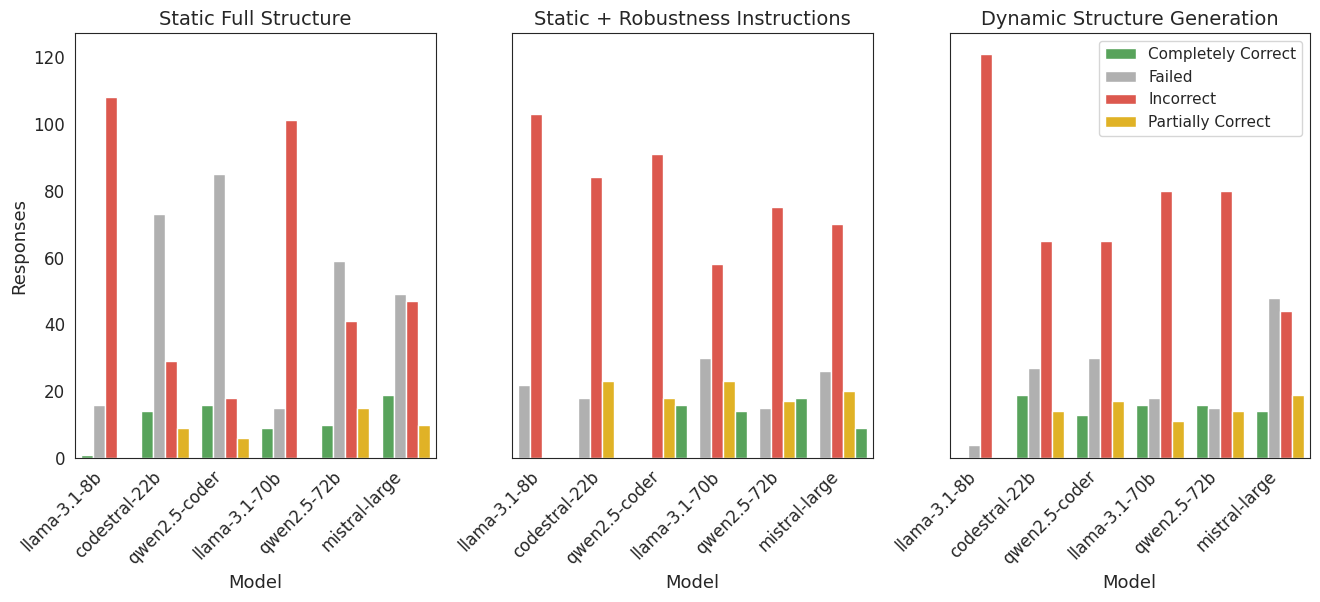

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

all_outcome_counts = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    df["Experiment"] = label
    df["Model"] = df["Model"].map(model_labels)

    counts = (
        df.groupby(["Model", "F1 Outcome"])
        .size()
        .reset_index(name="Count")
    )
    counts["Experiment"] = label
    all_outcome_counts.append(counts)

outcome_df = pd.concat(all_outcome_counts)

outcome_df["Model"] = pd.Categorical(outcome_df["Model"], categories=custom_order, ordered=True)

color_map = {
    "Completely Correct": "#4CAF50",
    "Partially Correct": "#FFC107",
    "Incorrect": "#F44336",
    "Failed": "#B0B0B0"
}

fig, axes = plt.subplots(1, 3, figsize=(13.3, 6.8), sharey=True)

for i, label in enumerate(experiment_titles):
    subset = outcome_df[outcome_df["Experiment"] == label]

    sns.barplot(
        data=subset,
        x="Model",
        y="Count",
        hue="F1 Outcome",
        palette=color_map,
        ax=axes[i]
    )

    axes[i].set_title(label, fontsize=14)
    axes[i].set_xlabel("Model", fontsize=13)
    axes[i].set_ylabel("Responses" if i == 0 else "", fontsize=13)
    axes[i].tick_params(axis='x', rotation=45, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    if i == 2:
        axes[i].legend(
            loc="upper right",
            frameon=True,
            fontsize=11,
        )
    else:
        axes[i].legend().remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
#plt.savefig("Images/Response Outcome Distribution per Model - With Data.png", dpi=600, bbox_inches='tight') 
plt.show()

In [27]:
custom_order_cat = pd.CategoricalDtype(categories=custom_order, ordered=True)

def highlight_min_max(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return [
        "background-color: #f28e8e" if minv else
        "background-color: #a8e6a3" if maxv else ""
        for minv, maxv in zip(is_min, is_max)
    ]

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Accuracy Bucket"] = df.apply(classify_f1, axis=1)
    df["Model"] = df["Model"].map(model_labels)

    model_acc = df.groupby(["Model", "Accuracy Bucket"]).size().unstack(fill_value=0)
    model_acc["Total"] = model_acc.sum(axis=1)

    model_acc_pct = pd.DataFrame()
    model_acc_pct["Completely Correct"] = (model_acc.get("Completely Correct", 0) / model_acc["Total"] * 100).round(1)
    model_acc_pct["Partially Correct"] = (model_acc.get("Partially Correct", 0) / model_acc["Total"] * 100).round(1)
    model_acc_pct["Incorrect"] = (model_acc.get("Incorrect", 0) / model_acc["Total"] * 100).round(1)
    model_acc_pct["Failure"] = (model_acc.get("Failed", 0) / model_acc["Total"] * 100).round(1)

    model_acc_pct.index = pd.CategoricalIndex(model_acc_pct.index, dtype=custom_order_cat)
    model_acc_pct = model_acc_pct.sort_index()

    styled_table = model_acc_pct.style.apply(highlight_min_max, axis=0)

    print(f"Accuracy Percentages by Model — {label}")
    display(styled_table)

Accuracy Percentages by Model — Static Full Structure


,Completely Correct,Partially Correct,Incorrect,Failure
Model,,,,
llama-3.1-8b,0.800000,0.000000,86.400000,12.800000
codestral-22b,11.200000,7.200000,23.200000,58.400000
qwen2.5-coder,12.800000,4.800000,14.400000,68.000000
llama-3.1-70b,7.200000,0.000000,80.800000,12.000000
qwen2.5-72b,8.000000,12.000000,32.800000,47.200000
mistral-large,15.200000,8.000000,37.600000,39.200000


Accuracy Percentages by Model — Static + Robustness Instructions


,Completely Correct,Partially Correct,Incorrect,Failure
Model,,,,
llama-3.1-8b,0.000000,0.000000,82.400000,17.600000
codestral-22b,0.000000,18.400000,67.200000,14.400000
qwen2.5-coder,12.800000,14.400000,72.800000,0.000000
llama-3.1-70b,11.200000,18.400000,46.400000,24.000000
qwen2.5-72b,14.400000,13.600000,60.000000,12.000000
mistral-large,7.200000,16.000000,56.000000,20.800000


Accuracy Percentages by Model — Dynamic Structure Generation


,Completely Correct,Partially Correct,Incorrect,Failure
Model,,,,
llama-3.1-8b,0.000000,0.000000,96.800000,3.200000
codestral-22b,15.200000,11.200000,52.000000,21.600000
qwen2.5-coder,10.400000,13.600000,52.000000,24.000000
llama-3.1-70b,12.800000,8.800000,64.000000,14.400000
qwen2.5-72b,12.800000,11.200000,64.000000,12.000000
mistral-large,11.200000,15.200000,35.200000,38.400000


In [28]:
all_outcome_counts = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Accuracy Bucket"] = df.apply(classify_f1, axis=1)
    df["Experiment"] = label
    df["Model"] = df["Model"].map(model_labels)

    counts = (
        df.groupby(["Model", "Accuracy Bucket"])
        .size()
        .reset_index(name="Count")
    )
    counts["Experiment"] = label
    all_outcome_counts.append(counts)

outcome_df = pd.concat(all_outcome_counts)

outcome_df["Model"] = pd.Categorical(outcome_df["Model"], categories=custom_order, ordered=True)

model_acc = outcome_df.groupby(["Model", "Accuracy Bucket"])["Count"].sum().unstack(fill_value=0)
model_acc["Total"] = model_acc.sum(axis=1)

model_acc_pct = pd.DataFrame({
    "Completely Correct": (model_acc.get("Completely Correct", 0) / model_acc["Total"] * 100).round(1),
    "Partially Correct": (model_acc.get("Partially Correct", 0) / model_acc["Total"] * 100).round(1),
    "Incorrect": (model_acc.get("Incorrect", 0) / model_acc["Total"] * 100).round(1),
    "Failure": (model_acc.get("Failed", 0) / model_acc["Total"] * 100).round(1),
})

print("Accuracy Percentages by Model:")
display(model_acc_pct)

exp_acc = outcome_df.groupby(["Experiment", "Accuracy Bucket"])["Count"].sum().unstack(fill_value=0)
exp_acc["Total"] = exp_acc.sum(axis=1)

exp_acc_pct = pd.DataFrame({
    "Completely Correct": (exp_acc.get("Completely Correct", 0) / exp_acc["Total"] * 100).round(1),
    "Partially Correct": (exp_acc.get("Partially Correct", 0) / exp_acc["Total"] * 100).round(1),
    "Incorrect": (exp_acc.get("Incorrect", 0) / exp_acc["Total"] * 100).round(1),
    "Failure": (exp_acc.get("Failed", 0) / exp_acc["Total"] * 100).round(1),
})

print("Accuracy Percentages by Experiment:")
display(exp_acc_pct)

Accuracy Percentages by Model:


,Completely Correct,Partially Correct,Incorrect,Failure
Model,,,,
llama-3.1-8b,0.3,0.0,88.5,11.2
codestral-22b,8.8,12.3,47.5,31.5
qwen2.5-coder,12.0,10.9,46.4,30.7
llama-3.1-70b,10.4,9.1,63.7,16.8
qwen2.5-72b,11.7,12.3,52.3,23.7
mistral-large,11.2,13.1,42.9,32.8


Accuracy Percentages by Experiment:


,Completely Correct,Partially Correct,Incorrect,Failure
Experiment,,,,
Dynamic Structure Generation,10.4,10.0,60.7,18.9
Static + Robustness Instructions,7.6,13.5,64.1,14.8
Static Full Structure,9.2,5.3,45.9,39.6


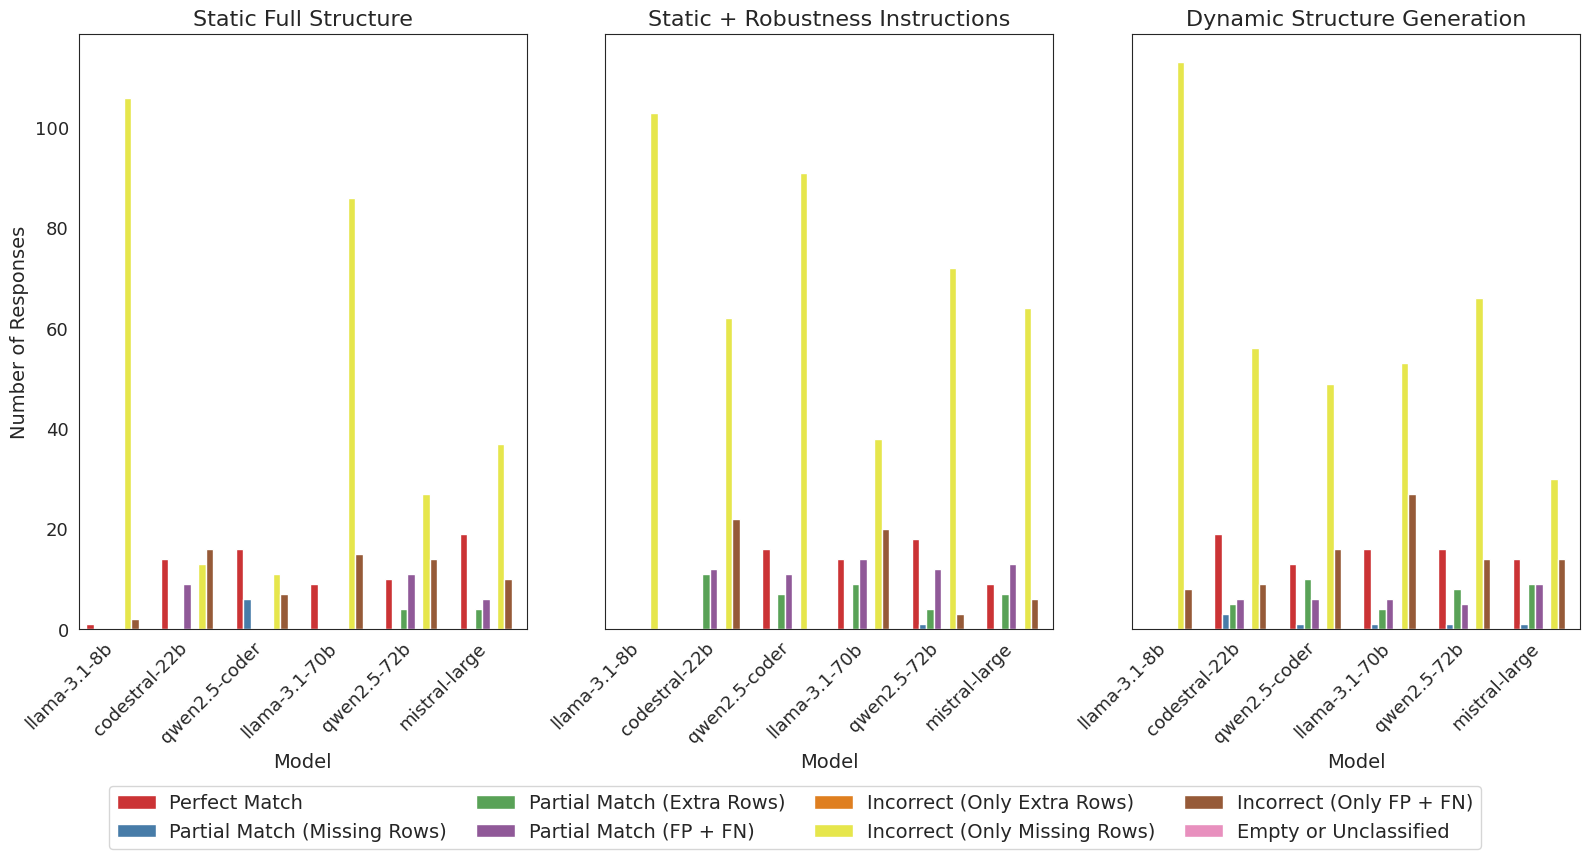

In [29]:
def classify_error(row):
    c, e, m = row["Correct Rows"], row["Extra Rows"], row["Missing Rows"]
    if c > 0 and e == 0 and m == 0:
        return "Perfect Match"
    elif c > 0 and e == 0 and m > 0:
        return "Partial Match (Missing Rows)"
    elif c > 0 and e > 0 and m == 0:
        return "Partial Match (Extra Rows)"
    elif c > 0 and e > 0 and m > 0:
        return "Partial Match (FP + FN)"
    elif c == 0 and e > 0 and m == 0:
        return "Incorrect (Only Extra Rows)"
    elif c == 0 and e == 0 and m > 0:
        return "Incorrect (Only Missing Rows)"
    elif c == 0 and e > 0 and m > 0:
        return "Incorrect (Only FP + FN)"
    else:
        return "Empty or Unclassified"

answer_type_order = [
    "Perfect Match",
    "Partial Match (Missing Rows)",
    "Partial Match (Extra Rows)",
    "Partial Match (FP + FN)",
    "Incorrect (Only Extra Rows)",
    "Incorrect (Only Missing Rows)",
    "Incorrect (Only FP + FN)",
    "Empty or Unclassified"
]

dataframes = []

for path in experiment_dirs:
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Model"] = df["Model"].map(model_labels)
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    
    df_filtered = df[df["F1 Outcome"] != "Failed"].copy()
    df_filtered["Answer Type"] = df_filtered.apply(classify_error, axis=1)
    df_filtered["Experiment"] = path
    dataframes.append(df_filtered)

df_all = pd.concat(dataframes, ignore_index=True)

df_all["Model"] = pd.Categorical(df_all["Model"], categories=custom_order, ordered=True)

df_all["Answer Type"] = pd.Categorical(df_all["Answer Type"], categories=answer_type_order, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 9), sharey=True)

for i, title in enumerate(experiment_titles):
    df_plot = df_all[df_all["Experiment"] == experiment_dirs[i]]
    counts = df_plot.groupby(["Model", "Answer Type"]).size().reset_index(name="Count")
    
    sns.barplot(
        data=counts,
        x="Model",
        y="Count",
        hue="Answer Type",
        palette="Set1",
        hue_order=answer_type_order,
        ax=axes[i]
    )

    axes[i].set_title(title, fontsize=16)
    axes[i].set_xlabel("Model", fontsize=14)
    axes[i].set_ylabel("Number of Responses" if i == 0 else "", fontsize=14)
    axes[i].tick_params(axis='x', rotation=45, labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    axes[i].legend().remove()

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    bbox_transform=fig.transFigure,
    ncol=4,
    columnspacing=1.5,
    handletextpad=0.7,
    fontsize=14,
    frameon=True
)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
#plt.savefig("Images/Answer Type Classification per Model — Across Experiments.png", dpi=600, bbox_inches='tight')
plt.show()

In [11]:
type_to_outcome = {
    "Perfect Match": "Correct",
    "Partial Match (Missing Rows)": "Partially Correct",
    "Partial Match (Extra Rows)": "Partially Correct",
    "Partial Match (FP + FN)": "Partially Correct",
    "Incorrect (Only Extra Rows)": "Incorrect",
    "Incorrect (Only Missing Rows)": "Incorrect",
    "Incorrect (Only FP + FN)": "Incorrect",
    "Empty or Unclassified": "Incorrect"
}

df_all["Outcome Bucket"] = df_all["Answer Type"].map(type_to_outcome)

model_summary = df_all.groupby(["Model", "Outcome Bucket"]).size().unstack(fill_value=0)
model_summary["Total"] = model_summary.sum(axis=1)
model_summary["% Correct"] = (model_summary["Correct"] / model_summary["Total"] * 100).round(1)
model_summary["% Partial"] = (model_summary["Partially Correct"] / model_summary["Total"] * 100).round(1)
model_summary["% Incorrect"] = (model_summary["Incorrect"] / model_summary["Total"] * 100).round(1)

model_summary = model_summary[["Correct", "Partially Correct", "Incorrect", "Total", "% Correct", "% Partial", "% Incorrect"]]

print("Summary by Model:")
display(model_summary)

exp_summary = df_all.groupby(["Experiment", "Outcome Bucket"]).size().unstack(fill_value=0)
exp_summary["Total"] = exp_summary.sum(axis=1)
exp_summary["% Correct"] = (exp_summary["Correct"] / exp_summary["Total"] * 100).round(1)
exp_summary["% Partial"] = (exp_summary["Partially Correct"] / exp_summary["Total"] * 100).round(1)
exp_summary["% Incorrect"] = (exp_summary["Incorrect"] / exp_summary["Total"] * 100).round(1)

exp_summary = exp_summary[["Correct", "Partially Correct", "Incorrect", "Total", "% Correct", "% Partial", "% Incorrect"]]

display(exp_summary)

📊 Summary by Model:


Outcome Bucket,Correct,Partially Correct,Incorrect,Total,% Correct,% Partial,% Incorrect
Model,,,,,,,
llama-3.1-8b,1,0,332,333,0.3,0.0,99.7
codestral-22b,33,46,178,257,12.8,17.9,69.3
qwen2.5-coder,45,41,174,260,17.3,15.8,66.9
llama-3.1-70b,39,34,239,312,12.5,10.9,76.6
qwen2.5-72b,44,46,196,286,15.4,16.1,68.5
mistral-large,42,49,161,252,16.7,19.4,63.9


Outcome Bucket,Correct,Partially Correct,Incorrect,Total,% Correct,% Partial,% Incorrect
Experiment,,,,,,,
First Experiment,69,40,344,453,15.2,8.8,75.9
Second Experiment,57,101,481,639,8.9,15.8,75.3
Third Experiment,78,75,455,608,12.8,12.3,74.8


In [30]:
model_answer_counts = df_all.groupby(["Model", "Answer Type"]).size().unstack(fill_value=0)

model_answer_pct = model_answer_counts.div(model_answer_counts.sum(axis=1), axis=0) * 100

model_answer_pct = model_answer_pct.round(1)

print("Percentage Summary by Model (Detailed Answer Types):")
display(model_answer_pct)

exp_answer_counts = df_all.groupby(["Experiment", "Answer Type"]).size().unstack(fill_value=0)

exp_answer_pct = exp_answer_counts.div(exp_answer_counts.sum(axis=1), axis=0) * 100

exp_answer_pct = exp_answer_pct.round(1)

print("Percentage Summary by Experiment (Detailed Answer Types):")
display(exp_answer_pct)

Percentage Summary by Model (Detailed Answer Types):


Answer Type,Perfect Match,Partial Match (Missing Rows),Partial Match (Extra Rows),Partial Match (FP + FN),Incorrect (Only Extra Rows),Incorrect (Only Missing Rows),Incorrect (Only FP + FN),Empty or Unclassified
Model,,,,,,,,
llama-3.1-8b,0.3,0.0,0.0,0.0,0.0,96.7,3.0,0.0
codestral-22b,12.8,1.2,6.2,10.5,0.0,51.0,18.3,0.0
qwen2.5-coder,17.3,2.7,6.5,6.5,0.0,58.1,8.8,0.0
llama-3.1-70b,12.5,0.3,4.2,6.4,0.0,56.7,19.9,0.0
qwen2.5-72b,15.4,0.7,5.6,9.8,0.0,57.7,10.8,0.0
mistral-large,16.7,0.4,7.9,11.1,0.0,52.0,11.9,0.0


Percentage Summary by Experiment (Detailed Answer Types):


Answer Type,Perfect Match,Partial Match (Missing Rows),Partial Match (Extra Rows),Partial Match (FP + FN),Incorrect (Only Extra Rows),Incorrect (Only Missing Rows),Incorrect (Only FP + FN),Empty or Unclassified
Experiment,,,,,,,,
First Experiment,15.2,1.3,1.8,5.7,0.0,61.8,14.1,0.0
Second Experiment,8.9,0.2,5.9,9.7,0.0,67.3,8.0,0.0
Third Experiment,12.8,1.2,5.9,5.3,0.0,60.4,14.5,0.0


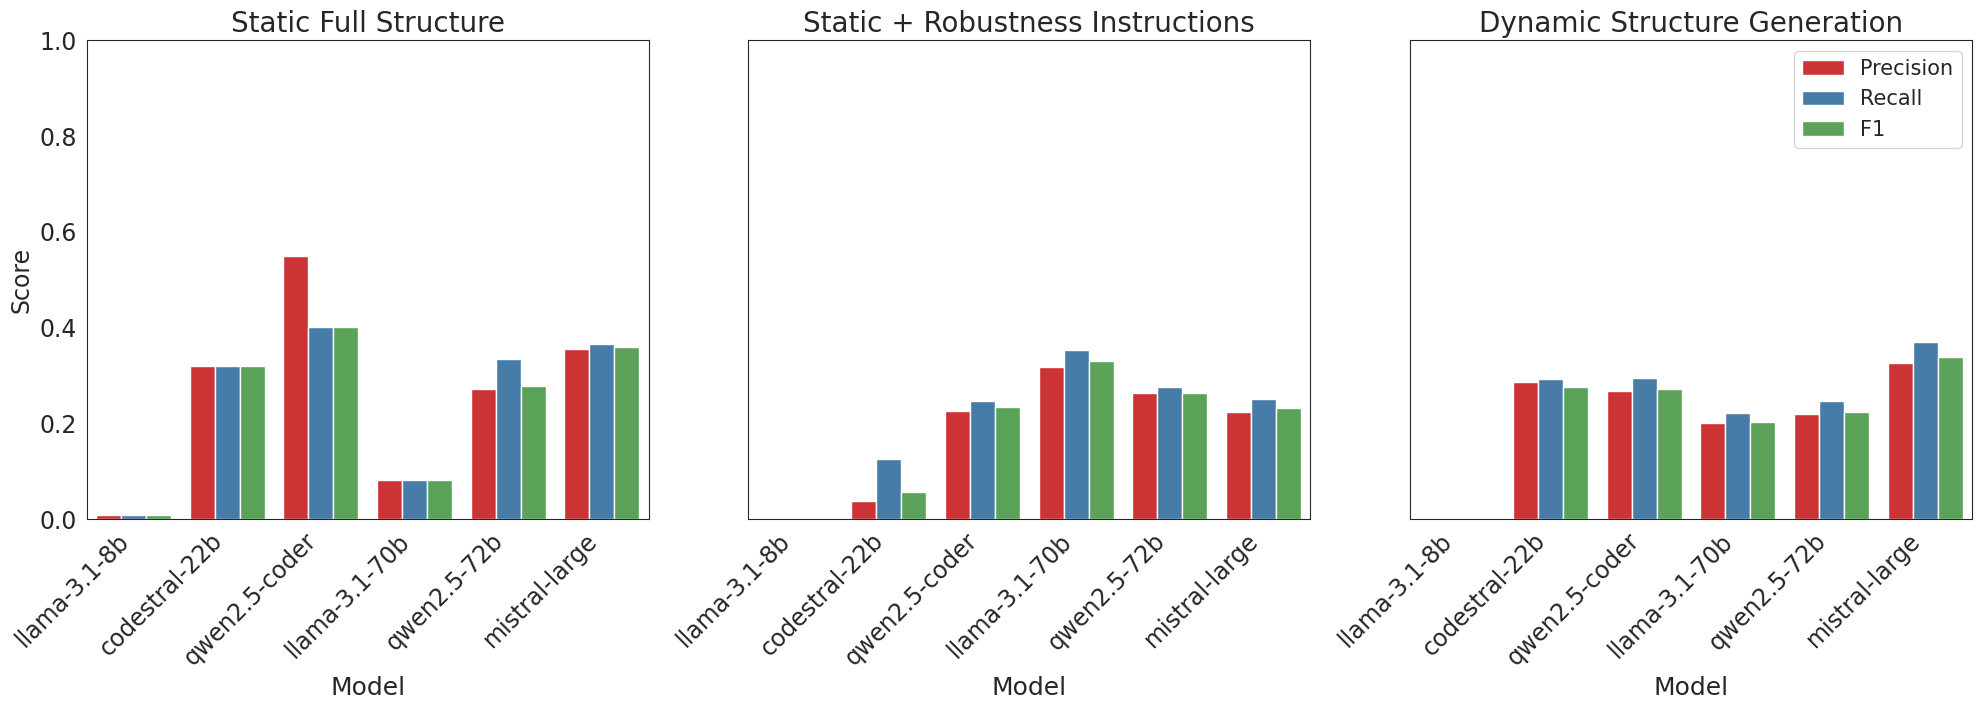

In [15]:
all_bars = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]

    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Precision"] = pd.to_numeric(df["Precision"], errors='coerce')
    df["Recall"] = pd.to_numeric(df["Recall"], errors='coerce')
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    df["Experiment"] = label
    df["Model"] = df["Model"].map(model_labels)

    # ✅ Only non-failed responses
    df_all = df[df["F1 Outcome"] != "Failed"]
    summary_all = df_all.groupby("Model")[["Precision", "Recall", "F1"]].mean().reset_index()
    melted_all = summary_all.melt(id_vars="Model", value_vars=["Precision", "Recall", "F1"],
                                  var_name="Metric", value_name="Score")
    melted_all["Experiment"] = label
    all_bars.append(melted_all)

all_melted = pd.concat(all_bars)

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

for i, label in enumerate(experiment_titles):
    subset_all = all_melted[all_melted["Experiment"] == label]
    
    sns.barplot(
        data=subset_all,
        x="Model",
        y="Score",
        hue="Metric",
        palette="Set1",
        ax=axes[i],
        order=custom_order
    )
    
    axes[i].set_title(f"{label}", fontsize=20)
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45, labelsize=17)
    axes[i].tick_params(axis='y', labelsize=17)
    axes[i].set_xlabel("Model", fontsize=18)
    axes[i].set_ylabel("Score" if i == 0 else "", fontsize=17)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    if i != 2:
        axes[i].legend().remove()
    else:
        axes[i].legend(loc="upper right", frameon=True, fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
#plt.savefig("Images/Evaluation of Model Performance Across Experiments.png", dpi=600, bbox_inches='tight')
plt.show()

In [14]:
summary_tables = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]

    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    df["Model"] = df["Model"].map(model_labels)

    df_filtered = df[df["F1 Outcome"] != "Failed"]

    grouped = df_filtered.groupby("Model")["F1"].agg(["mean", "std"]).reset_index()
    grouped["F1 Summary"] = grouped.apply(lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1)
    grouped["Experiment"] = label

    summary_tables.append(grouped[["Model", "F1 Summary", "Experiment"]])

summary_df = pd.concat(summary_tables)
summary_pivot = summary_df.pivot(index="Model", columns="Experiment", values="F1 Summary")

summary_pivot = summary_pivot.reindex(custom_order)
summary_pivot = summary_pivot[experiment_titles]

summary_pivot = summary_pivot.fillna("–")
display(summary_pivot)

Experiment,Static Full Structure,Static + Robustness Instructions,Dynamic Structure Generation
Model,,,
llama-3.1-8b,0.01 ± 0.10,0.00 ± 0.00,0.00 ± 0.00
codestral-22b,0.32 ± 0.44,0.06 ± 0.14,0.28 ± 0.43
qwen2.5-coder,0.40 ± 0.49,0.23 ± 0.39,0.27 ± 0.42
llama-3.1-70b,0.08 ± 0.28,0.33 ± 0.43,0.20 ± 0.38
qwen2.5-72b,0.28 ± 0.41,0.26 ± 0.41,0.22 ± 0.39
mistral-large,0.36 ± 0.47,0.23 ± 0.38,0.34 ± 0.44


In [31]:
import pandas as pd

dataframes = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    
    df = df[df["No Data"] == False]
    
    df["Precision"] = pd.to_numeric(df["Precision"], errors='coerce')
    df["Recall"] = pd.to_numeric(df["Recall"], errors='coerce')
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    
    df["Model"] = df["Model"].map(model_labels)
    
    df["Experiment"] = label
    
    dataframes.append(df)

df_all = pd.concat(dataframes, ignore_index=True)

df_all["Model"] = pd.Categorical(df_all["Model"], categories=custom_order, ordered=True)

df_metrics = df_all[df_all["F1 Outcome"] != "Failed"]

model_exp_metrics = (
    df_metrics.groupby(["Model", "Experiment"])[["Precision", "Recall", "F1"]]
    .mean()
    .round(3)
    .reset_index()
)

pivoted_metrics = model_exp_metrics.pivot(index="Model", columns="Experiment", values=["Precision", "Recall", "F1"])
pivoted_metrics = pivoted_metrics.round(3)

print("Pivoted Precision, Recall, and F1 (Models as rows, Experiments as columns):")
display(pivoted_metrics)

Pivoted Precision, Recall, and F1 (Models as rows, Experiments as columns):


Precision                                   \
Experiment    Dynamic Structure Generation Static + Robustness Instructions   
Model                                                                         
llama-3.1-8b                         0.000                            0.000   
codestral-22b                        0.287                            0.038   
qwen2.5-coder                        0.267                            0.225   
llama-3.1-70b                        0.202                            0.317   
qwen2.5-72b                          0.219                            0.264   
mistral-large                        0.327                            0.223   

                                                          Recall  \
Experiment    Static Full Structure Dynamic Structure Generation   
Model                                                              
llama-3.1-8b                  0.009                        0.000   
codestral-22b                 0.319                        0.292   
qwen2.5-coder                 0.550                        0.294   
llama-3.1-70b                 0.082                        0.222   
qwen2.5-72b                   0.272                        0.246   
mistral-large                 0.354                        0.370   

                                                                      \
Experiment    Static + Robustness Instructions Static Full Structure   
Model                                                                  
llama-3.1-8b                             0.000                 0.009   
codestral-22b                            0.125                 0.321   
qwen2.5-coder                            0.248                 0.401   
llama-3.1-70b                            0.353                 0.082   
qwen2.5-72b                              0.275                 0.335   
mistral-large                            0.251                 0.366   

                                        F1                                   \
Experiment    Dynamic Structure Generation Static + Robustness Instructions   
Model                                                                         
llama-3.1-8b                         0.000                            0.000   
codestral-22b                        0.276                            0.056   
qwen2.5-coder                        0.271                            0.233   
llama-3.1-70b                        0.203                            0.330   
qwen2.5-72b                          0.223                            0.263   
mistral-large                        0.338                            0.232   

                                     
Experiment    Static Full Structure  
Model                                
llama-3.1-8b                  0.009  
codestral-22b                 0.320  
qwen2.5-coder                 0.402  
llama-3.1-70b                 0.082  
qwen2.5-72b                   0.279  
mistral-large                 0.359

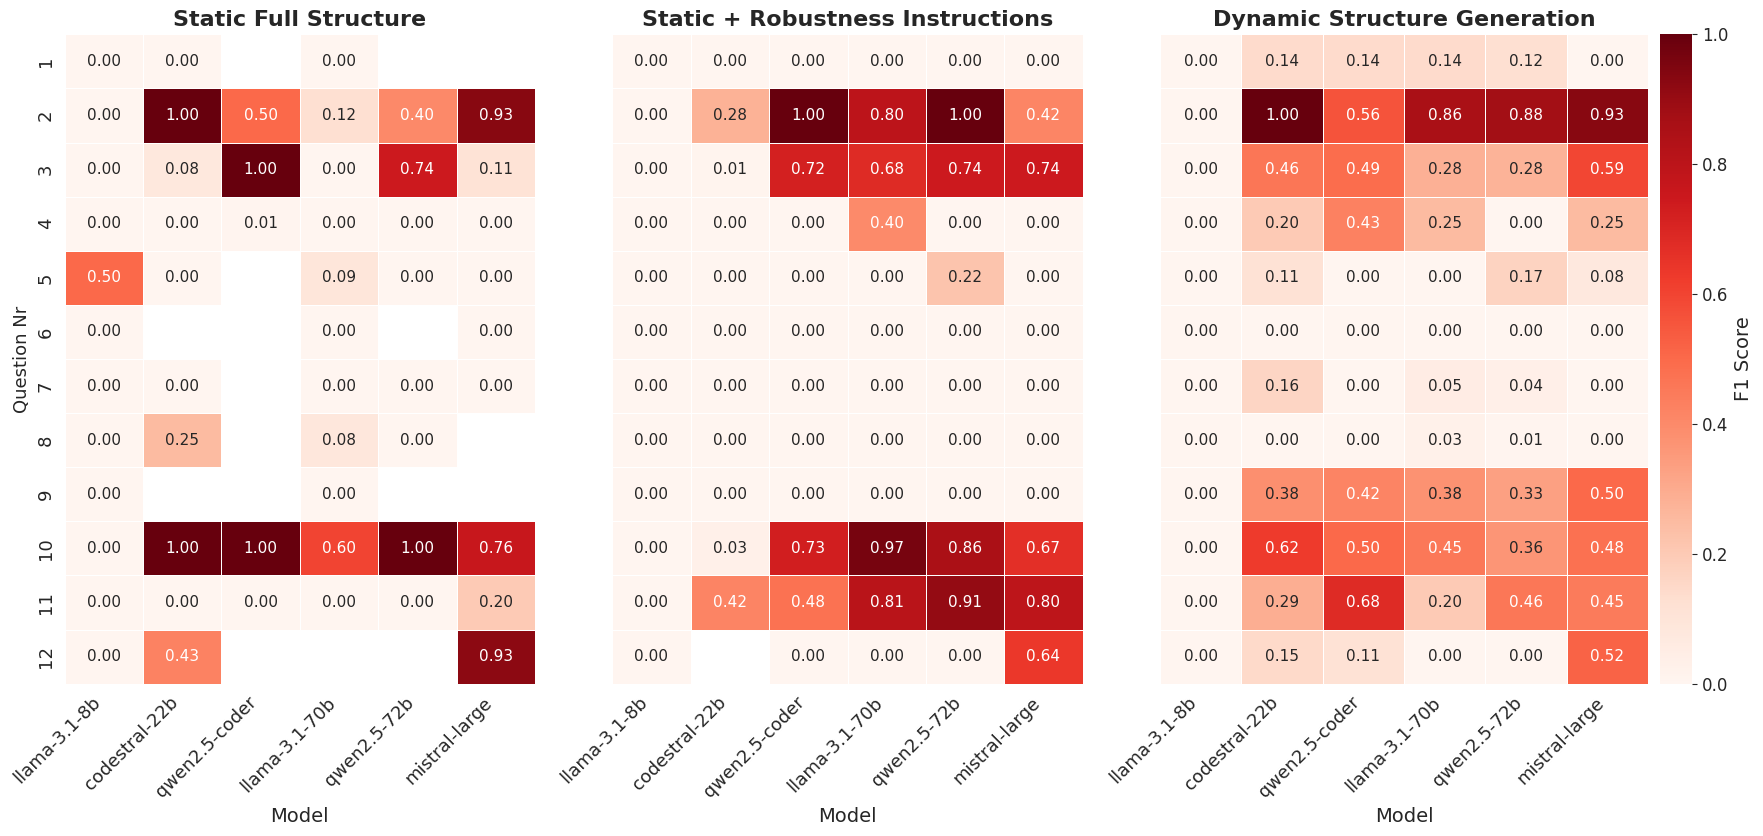

In [16]:
queries = [
    "What topics does Instagram determine to be of interest for a user?",
    "How often does a user see advertisements and about which topics (from which companies)?",
    "How often do people see posts(daily and weekly)?",
    "Which companies have access to your Instagram activity or information?",
    "Which devices has the user logged in from and when?",
    "What Instagram account changes (e.g., name, phone, email) has the user made over time?",
    "Whose stories does the user tend to engage with most often?",
    "Which accounts has the user interacted with most often through post likes, story likes and comments(Top 20)?",
    "Which profiles does the user follow that do not follow him back?",
    "How often does the user view content (including both posts and videos) and from which accounts?",
    "Which accounts has the user viewed posts from but not liked them?",
    "How many messages does the user send per week?"
]
query_map = {q: i+1 for i, q in enumerate(queries)}

fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 9),
    sharey=True,
    gridspec_kw={'width_ratios': [1, 1, 1.25]}
)

for i, (label, path) in enumerate(zip(experiment_titles, experiment_dirs)):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Question Nr"] = df["Question"].map(query_map)
    df["Model"] = df["Model"].map(model_labels)

    df_success = df[df["F1"].notna() & (df["F1"] >= 0)]
    pivot = df_success.pivot_table(index="Question Nr", columns="Model", values="F1", aggfunc="mean")
    pivot = pivot.reindex(index=range(1, 13), columns=custom_order)

    sns.heatmap(
        pivot,
        ax=axes[i],
        cmap="Reds",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        linecolor="white",
        cbar=(i == 2),
        cbar_kws={
            "label": "F1 Score",
            "shrink": 1.0,
            "aspect": 20,
            "pad": 0.02
        } if i == 2 else None,
        annot_kws={"fontsize": 11}
    )

    if i == 2:
        cbar = axes[i].collections[0].colorbar
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label("F1 Score", fontsize=14) 

    axes[i].set_title(f"{label}", fontsize=16, fontweight="bold")
    axes[i].set_xlabel("Model", fontsize=14)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    if i == 0:
        axes[i].set_ylabel("Question Nr", fontsize=13)
    else:
        axes[i].set_ylabel("")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
#plt.savefig("Images/F1 Score Heatmaps (Model × Question).png", dpi=600, bbox_inches='tight') 
plt.show()

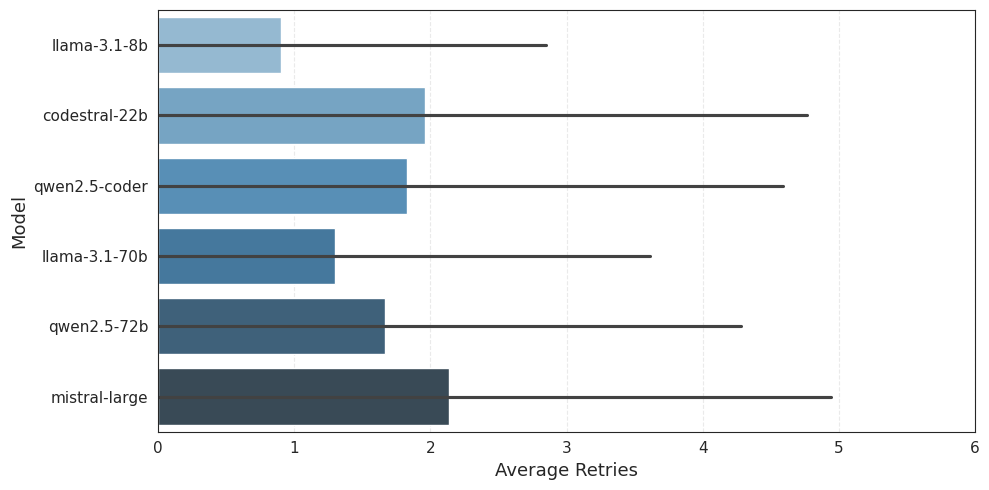

In [32]:
all_dfs = []

for path in experiment_dirs:
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df["Number of Retries"] = pd.to_numeric(df["Number of Retries"], errors='coerce')
    df["Model"] = df["Model"].map(model_labels)
    all_dfs.append(df)

df_retry = pd.concat(all_dfs, ignore_index=True)

df_retry["Model"] = pd.Categorical(df_retry["Model"], categories=custom_order, ordered=True)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_retry,
    x="Number of Retries",
    y="Model",
    estimator="mean",
    ci="sd",
    palette="Blues_d"
)

plt.xlabel("Average Retries", fontsize=13)
plt.ylabel("Model", fontsize=13)
plt.xlim(0, 6) 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle="--", alpha=0.4)
plt.tight_layout()
#plt.savefig("Images/Average Number of Retries per Model .png", dpi=600, bbox_inches='tight') 
plt.show()

In [19]:
retry_summary_tables = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df["Number of Retries"] = pd.to_numeric(df["Number of Retries"], errors='coerce')
    df["Model"] = df["Model"].map(model_labels)

    grouped = df.groupby("Model")["Number of Retries"].agg(["mean", "std"]).reset_index()
    grouped["Retry Summary"] = grouped.apply(lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1)
    grouped["Experiment"] = label

    retry_summary_tables.append(grouped[["Model", "Retry Summary", "Experiment"]])

retry_summary_df = pd.concat(retry_summary_tables)

retry_summary_pivot = retry_summary_df.pivot(index="Model", columns="Experiment", values="Retry Summary")

retry_summary_pivot = retry_summary_pivot.reindex(custom_order)
retry_summary_pivot = retry_summary_pivot[experiment_titles]

retry_summary_pivot = retry_summary_pivot.fillna("–")
display(retry_summary_pivot)

Experiment,Static Full Structure,Static + Robustness Instructions,Dynamic Structure Generation
Model,,,
llama-3.1-8b,0.94 ± 2.03,1.22 ± 2.23,0.54 ± 1.45
codestral-22b,3.80 ± 2.89,0.82 ± 2.05,1.26 ± 2.44
qwen2.5-coder,4.12 ± 2.79,0.00 ± 0.00,1.37 ± 2.51
llama-3.1-70b,0.99 ± 1.99,1.74 ± 2.62,1.17 ± 2.22
qwen2.5-72b,3.16 ± 2.96,0.72 ± 1.93,1.13 ± 2.15
mistral-large,2.55 ± 2.93,1.61 ± 2.51,2.24 ± 2.90


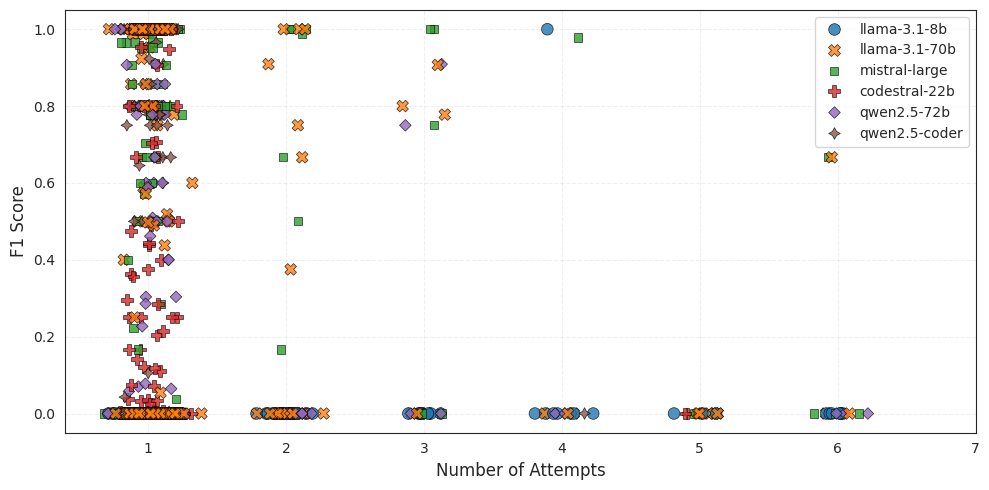

In [18]:
import numpy as np

all_dfs = []

for path in experiment_dirs:
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Number of Retries"] = pd.to_numeric(df["Number of Retries"], errors='coerce')
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    df["Model"] = df["Model"].map(model_labels)
    all_dfs.append(df)

df_combined = pd.concat(all_dfs, ignore_index=True)
df_filtered_all = df_combined[df_combined["F1 Outcome"] != "Failed"].copy()

# Apply jitter to make scatter plot clearer
np.random.seed(42)
df_filtered_all["Retries Jittered"] = df_filtered_all["Number of Retries"] + np.random.normal(0, 0.1, size=len(df_filtered_all))

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df_filtered_all,
    x="Retries Jittered",
    y="F1",
    hue="Model",
    style="Model",
    palette="tab10",
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5,
    s=70
)

plt.xlabel("Number of Attempts", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.xticks(ticks=range(0, 7), labels=[str(i + 1) for i in range(0, 7)])
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="upper right", frameon=True)
plt.tight_layout()
#plt.savefig("Images/Number of Retries vs F1 Score.png", dpi=600, bbox_inches='tight') 
plt.show()

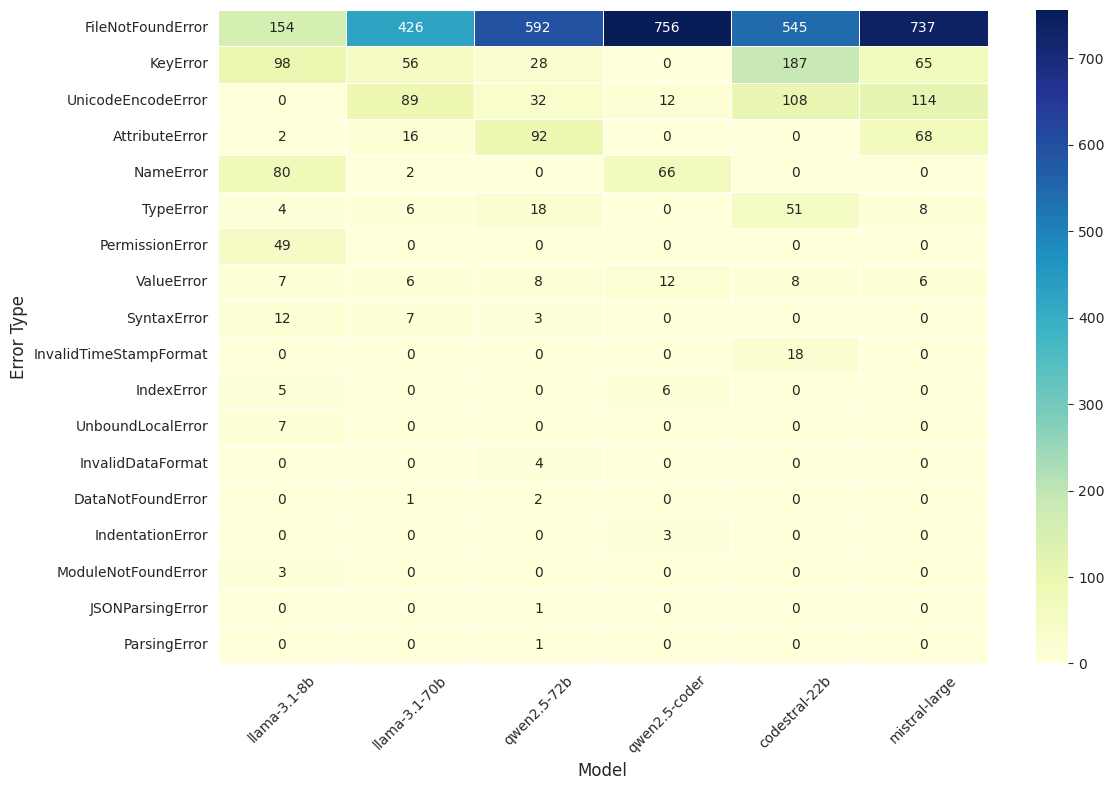

In [2]:
error_dfs = []

for path in experiment_dirs:
    df_error = pd.read_csv(f"{path}/processed_error_log.csv")
    df_error["Model"] = df_error["Model"].map(model_labels)
    error_dfs.append(df_error)

df_errors_all = pd.concat(error_dfs, ignore_index=True)

error_counts = (
    df_errors_all.groupby(["Error Type", "Model"])
    .size()
    .reset_index(name="Count")
)

heatmap_data = error_counts.pivot(index="Error Type", columns="Model", values="Count").fillna(0)

row_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
col_totals = heatmap_data.sum(axis=0).sort_values(ascending=True)

heatmap_sorted = heatmap_data.loc[row_totals.index, col_totals.index]

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_sorted,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="white"
)

plt.xlabel("Model", fontsize=12)
plt.ylabel("Error Type", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig("Images/Error Type Frequency per Model.png", dpi=600, bbox_inches='tight') 
plt.show()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from matplotlib.lines import Line2D

error_dfs = []
for label, path in zip(experiment_titles, experiment_dirs):
    df_err = pd.read_csv(f"{path}/processed_error_log.csv", na_values=["", " "])
    df_err["Experiment"] = label
    df_err["Model"] = df_err["Model"].map(model_labels)
    # make sure numeric
    if "Attempt Number" in df_err.columns:
        df_err["Attempt Number"] = pd.to_numeric(df_err["Attempt Number"], errors="coerce").fillna(0).astype(int)
    error_dfs.append(df_err)

df_errors = pd.concat(error_dfs, ignore_index=True)

df_errors["Model"] = pd.Categorical(df_errors["Model"], categories=custom_order, ordered=True)

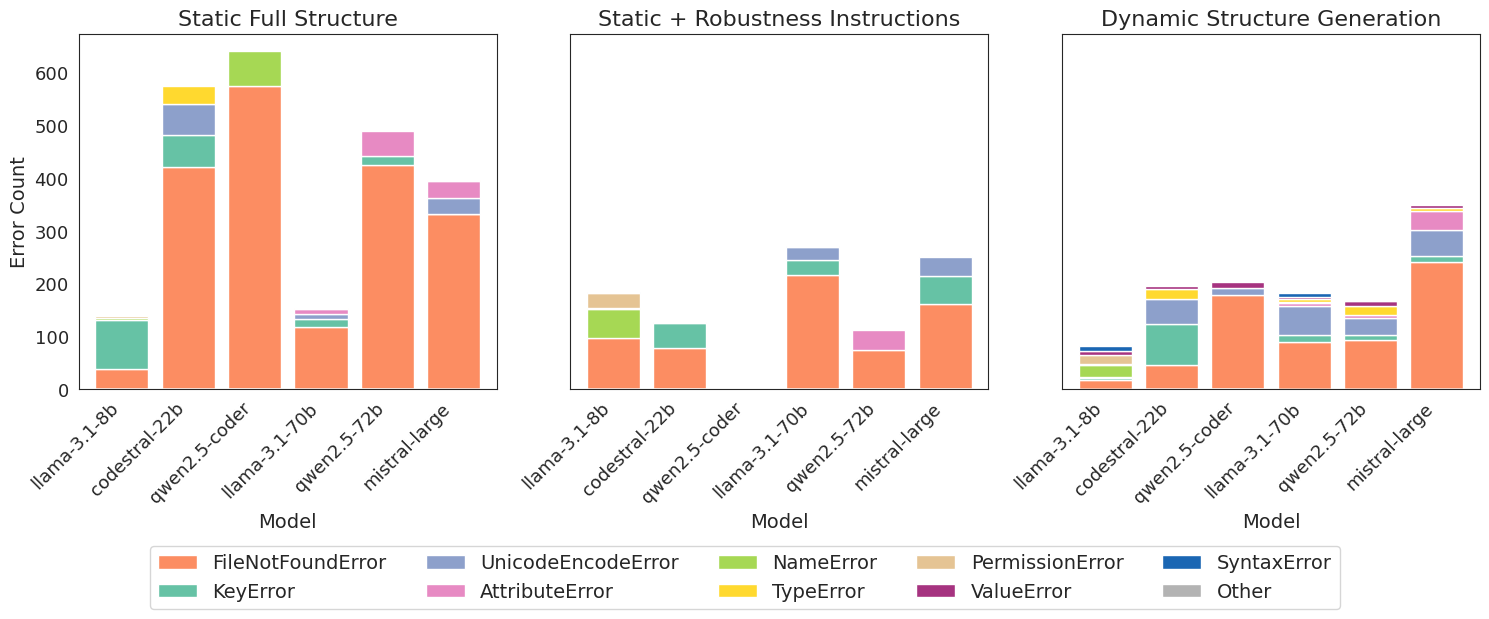

In [5]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

top_errors = ( df_errors["Error Type"] .value_counts() .nlargest(9) .index .tolist() )

all_error_types = top_errors + ["Other"]

set2 = sns.color_palette("Set2", n_colors=8)
reserved_orange = set2[1]
other_color = set2[-1]

palette_for_others = [c for i, c in enumerate(set2[:-1]) if i != 1]

extra_colors = [(0.65, 0.2, 0.5), (0.1, 0.4, 0.7)]

top_colors = []
for err in top_errors:
    if err == "FileNotFoundError":
        top_colors.append(reserved_orange)
    else:
        if palette_for_others:
            top_colors.append(palette_for_others.pop(0))
        else:
            top_colors.append(extra_colors.pop(0))

color_dict = dict(zip(top_errors, top_colors))
color_dict["Other"] = other_color

n_exps = len(experiment_titles)
fig, axes = plt.subplots(1, n_exps, figsize=(5*n_exps, 6), sharey=True)

for i, label in enumerate(experiment_titles):
    ax = axes[i] if n_exps > 1 else axes
    df_e = df_errors[df_errors["Experiment"] == label].copy()
    
    pivot = df_e.groupby(["Model", "Error Type"]).size().unstack(fill_value=0)
    pivot = pivot.reindex(columns=all_error_types, fill_value=0)
    pivot = pivot.reindex(custom_order).fillna(0)
    
    pivot.plot(
        kind="bar", 
        stacked=True, 
        ax=ax, 
        color=[color_dict[c] for c in pivot.columns], 
        width=0.8, 
        legend=False
    )

    ax.set_title(label, fontsize=16)
    ax.set_xlabel("Model", fontsize=14)
    ax.set_ylabel("Error Count" if i == 0 else "", fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment("right")

handles = [Patch(facecolor=color_dict[err]) for err in all_error_types]
fig.legend(
    handles,
    all_error_types,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.09),
    ncol=5,
    frameon=True,
    fontsize=14,
    title_fontsize=16,
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig("Images/Error Type Distribution per Model.png", dpi=600, bbox_inches='tight') 
plt.show()

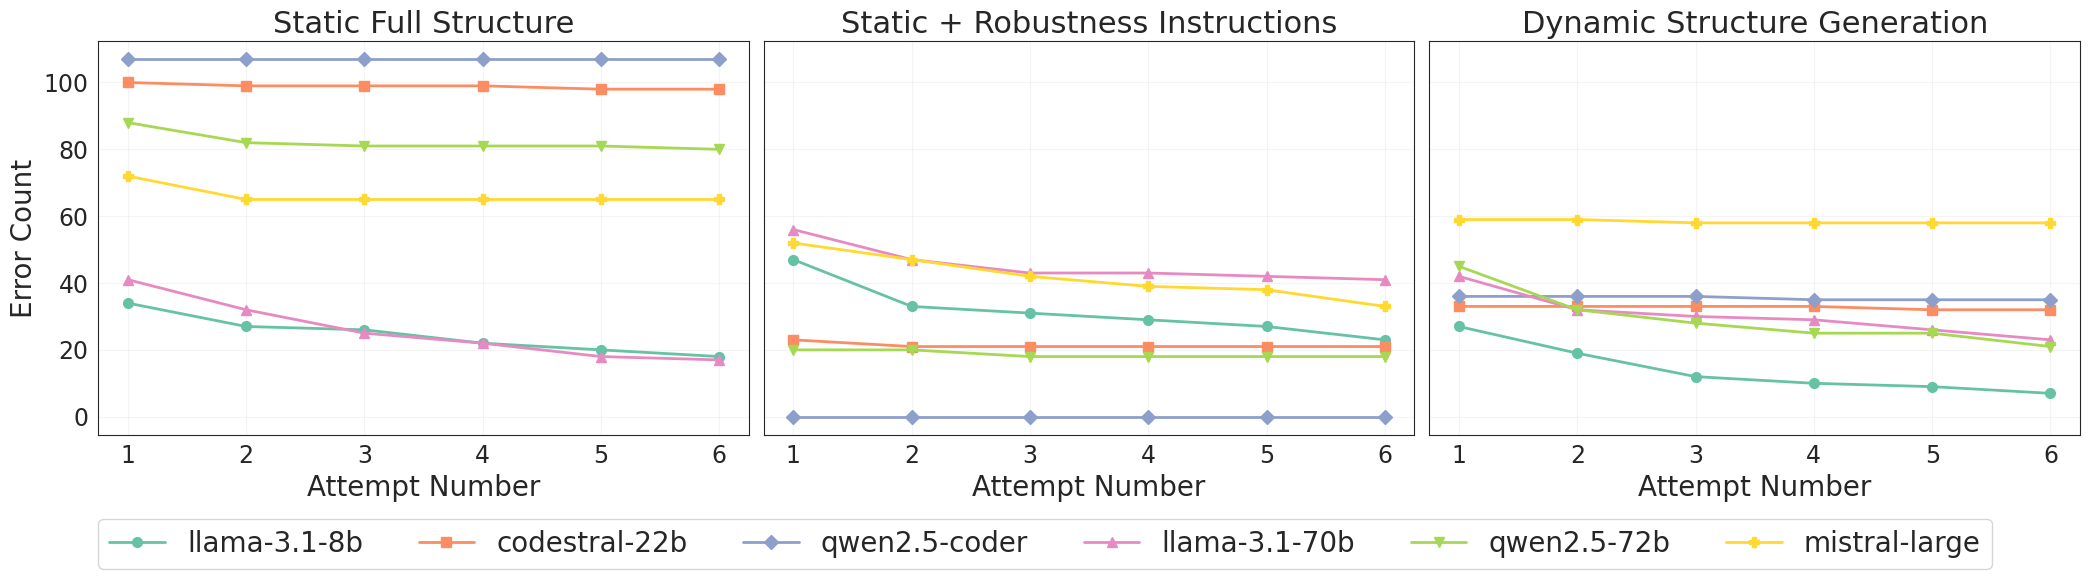

In [18]:
from matplotlib.colors import to_hex

markers = ["o", "s", "D", "^", "v", "P", "*", "X", "h", "<", ">"]
model_marker_map = {model: markers[i % len(markers)] for i, model in enumerate(custom_order)}

shared_palette = sns.color_palette("Set2", n_colors=len(custom_order))

model_color_map = dict(zip(custom_order, map(to_hex, shared_palette))) 

max_attempt = int(df_errors["Attempt Number"].max() if "Attempt Number" in df_errors.columns else 1)
fig, axes = plt.subplots(1, n_exps, figsize=(7 * n_exps, 6), sharey=True)

for i, label in enumerate(experiment_titles):
    ax = axes[i] if n_exps > 1 else axes
    df_e = df_errors[df_errors["Experiment"] == label].copy()
    if "Attempt Number" not in df_e.columns:
        ax.text(0.5, 0.5, "No Attempt Number column", ha="center", fontsize=16)
        continue

    trend = df_e.groupby(["Attempt Number", "Model"]).size().reset_index(name="Error Count")
    all_attempts = range(1, max_attempt+1)
    
    for model in custom_order:
        tmp = trend[trend["Model"] == model].set_index("Attempt Number").reindex(all_attempts, fill_value=0).reset_index()
        ax.plot(
            tmp["Attempt Number"],
            tmp["Error Count"],
            marker=model_marker_map[model],
            color=model_color_map[model],
            label=model,
            linestyle='-',
            linewidth=2,
            markersize=7
        )

    ax.set_title(label, fontsize=22)
    ax.set_xlabel("Attempt Number", fontsize=20)
    if i == 0:
        ax.set_ylabel("Error Count", fontsize=20)
    else:
        ax.set_ylabel("")
    
    if max_attempt > 10:
        ax.set_xticks([x for x in all_attempts if x % 2 == 1])
    else:
        ax.set_xticks(all_attempts)
    
    ax.tick_params(axis='x', labelsize=17)
    ax.tick_params(axis='y', labelsize=17)
    ax.grid(alpha=0.2)

    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment("center")

handles, labels_ = [], []
for ax in (axes if n_exps > 1 else [axes]):
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels_.extend(l)

unique = dict(zip(labels_, handles))
fig.legend(
    unique.values(),
    unique.keys(),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.06),
    ncol=min(6, len(unique)),
    fontsize=20,
    frameon=True
)

plt.tight_layout(rect=[0, 0.05, 1, 0.92])  # leave room for legend
#plt.savefig("Images/Error Trend Over Attempts.png", dpi=600, bbox_inches='tight') 
plt.show()

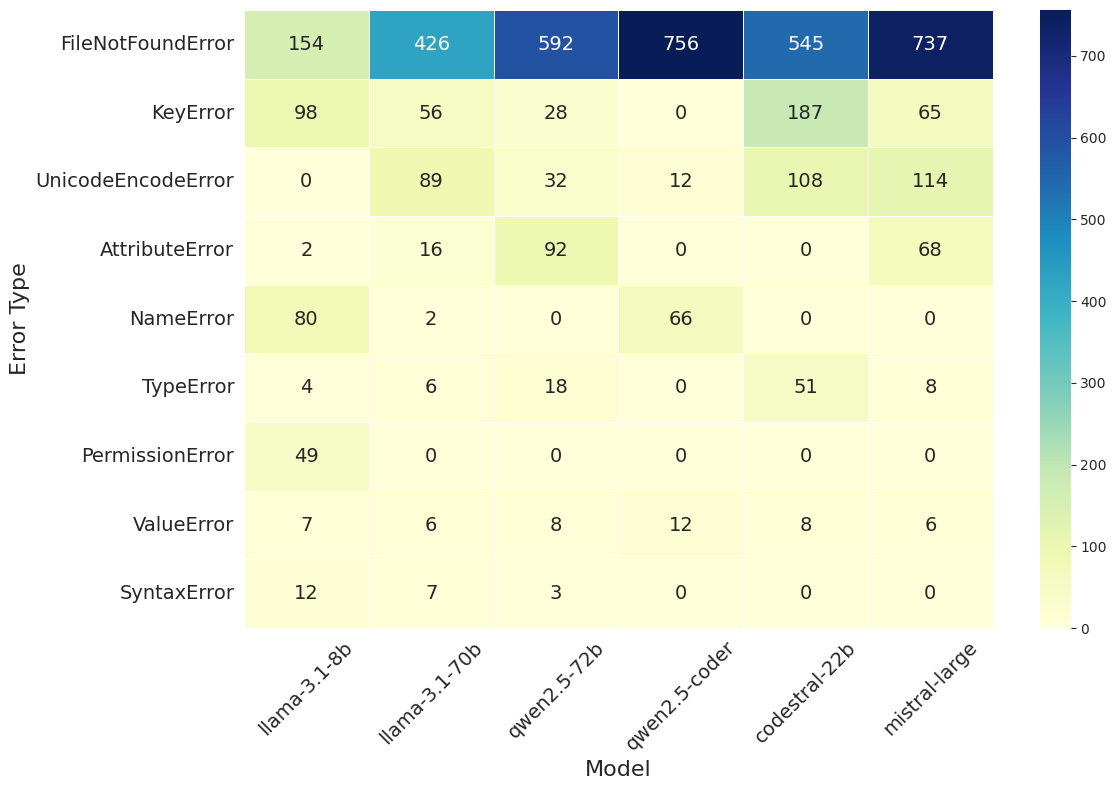

In [21]:
error_dfs = []

for path in experiment_dirs:
    df_error = pd.read_csv(f"{path}/processed_error_log.csv")
    df_error["Model"] = df_error["Model"].map(model_labels)
    error_dfs.append(df_error)

df_errors_all = pd.concat(error_dfs, ignore_index=True)

error_counts = (
    df_errors_all.groupby(["Error Type", "Model"])
    .size()
    .reset_index(name="Count")
)

heatmap_data = error_counts.pivot(index="Error Type", columns="Model", values="Count").fillna(0)

row_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
col_totals = heatmap_data.sum(axis=0).sort_values(ascending=True)

heatmap_sorted = heatmap_data.loc[row_totals.index, col_totals.index]

heatmap_top9 = heatmap_sorted.head(9)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_top9,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="white",
    annot_kws={"fontsize": 14}
)

plt.xlabel("Model", fontsize=16)
plt.ylabel("Error Type", fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig("Images/Error Type Frequency per Model.png", dpi=600, bbox_inches='tight') 
plt.show()

In [24]:
# Persistent Errors, Errors that appear 6 times in a failing instance
error_streaks = df_errors_all.groupby(["Experiment ID", "Error Type"]).size().reset_index(name="Occurrences")

max_persistence = error_streaks[error_streaks["Occurrences"] == 6]

unique_error_types_df = max_persistence[["Error Type"]].drop_duplicates().reset_index(drop=True)
display(unique_error_types_df)

,Error Type
0,FileNotFoundError
1,KeyError
2,UnicodeEncodeError
3,NameError
4,TypeError
5,ValueError
6,AttributeError
7,SyntaxError
8,PermissionError
9,InvalidTimeStampFormat


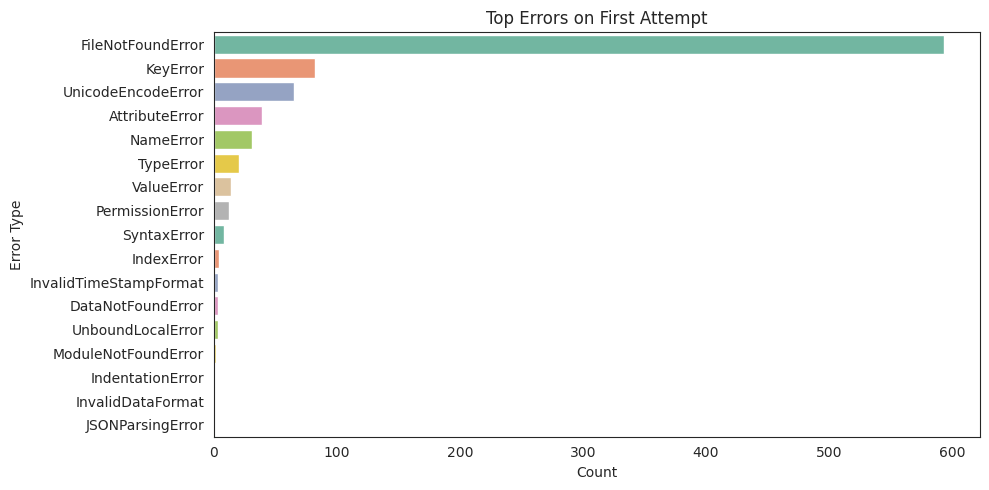

In [25]:
first_attempt_errors = df_errors_all[df_errors_all["Attempt Number"] == 1]
top_first_errors = first_attempt_errors["Error Type"].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=top_first_errors.values, y=top_first_errors.index, palette="Set2")
plt.title("Top Errors on First Attempt")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

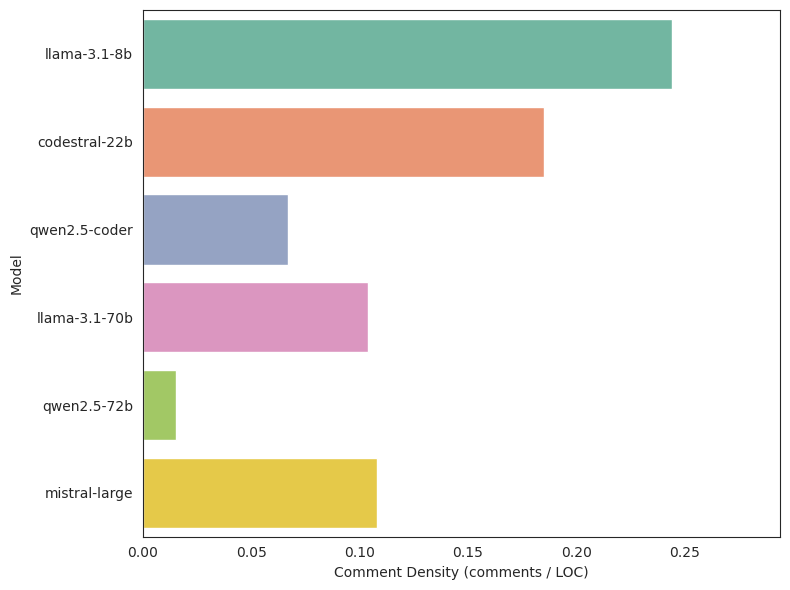

In [35]:
from matplotlib.colors import to_hex

shared_palette = sns.color_palette("Set2", n_colors=len(custom_order))

model_color_map = dict(zip(custom_order, map(to_hex, shared_palette)))

all_dfs = []

for path in experiment_dirs:
    df = pd.read_csv(f"{path}/code_evaluation_log.csv", na_values=["", " "])
    df["Model"] = df["Model"].map(model_labels)
    all_dfs.append(df)

df_code = pd.concat(all_dfs, ignore_index=True)
df_code["comment_density"] = df_code["raw_comments"] / df_code["raw_loc"]

comment_summary = df_code.groupby("Model")["comment_density"].mean().round(3)
comment_summary = comment_summary.reindex(custom_order)

recommended_density = 0.2

plt.figure(figsize=(8, 6))
sns.barplot(
    y=comment_summary.index,
    x=comment_summary.values,
    palette=[model_color_map[model] for model in comment_summary.index],
    orient='h'
)

plt.xlabel("Comment Density (comments / LOC)")
plt.ylabel("Model")
plt.xlim(0, max(comment_summary.values.max(), recommended_density) + 0.05)
plt.tight_layout()
#plt.savefig("Images/Comment Density.png", dpi=600, bbox_inches='tight') 
plt.show()

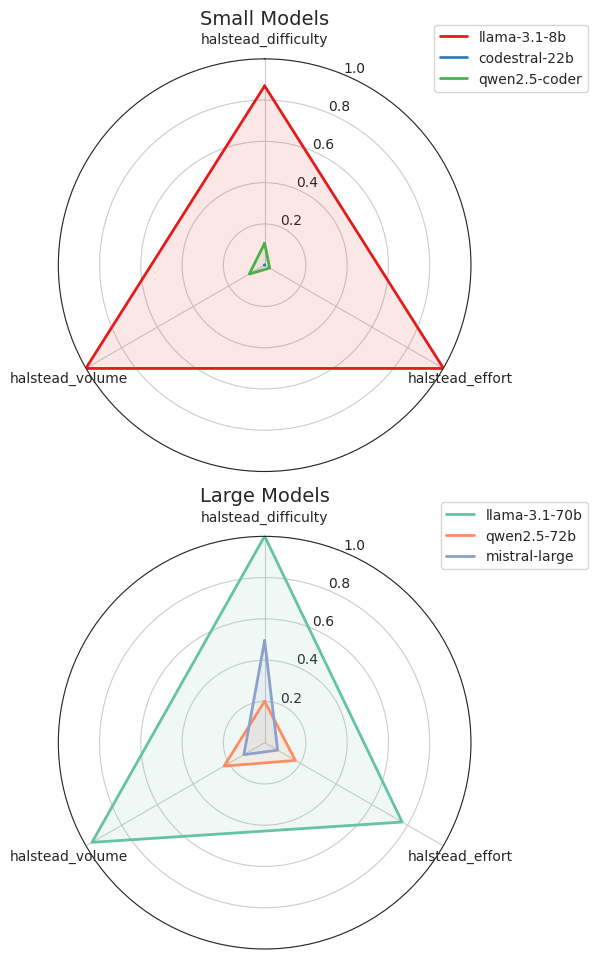

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

halstead_cols = ["halstead_difficulty", "halstead_effort", "halstead_volume"]
all_code_dfs = []

for path in experiment_dirs:
    df_code = pd.read_csv(f"{path}/code_evaluation_log.csv")
    df_code["Model"] = df_code["Model"].map(model_labels)
    all_code_dfs.append(df_code)

df_code_all = pd.concat(all_code_dfs, ignore_index=True)

halstead_summary = df_code_all.groupby("Model")[halstead_cols].mean()

scaler = MinMaxScaler()
halstead_normalized = pd.DataFrame(
    scaler.fit_transform(halstead_summary),
    index=halstead_summary.index,
    columns=halstead_summary.columns
)
halstead_normalized += 1e-3  # Small offset to avoid full collapse

labels = halstead_cols
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, axs = plt.subplots(2, 1, figsize=(12, 10), subplot_kw=dict(polar=True))  # Taller format

palette_small = sns.color_palette("Set1", len(small_models))
palette_large = sns.color_palette("Set2", len(large_models))

for i, group in enumerate(model_groups):
    ax = axs[i]
    colors = palette_small if i == 0 else palette_large

    for j, model in enumerate(group):
        if model in halstead_normalized.index:
            values = halstead_normalized.loc[model].tolist()
            values += values[:1]  # close the loop
            ax.plot(angles, values, label=model, linewidth=2, color=colors[j])
            ax.fill(angles, values, alpha=0.1, color=colors[j])
        else:
            print(f"⚠️ Model '{model}' not found!")

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.set_title("Small Models" if i == 0 else "Large Models", fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.savefig("Images/Halstead_Radar_Vertical.png", dpi=600, bbox_inches='tight')
plt.show()

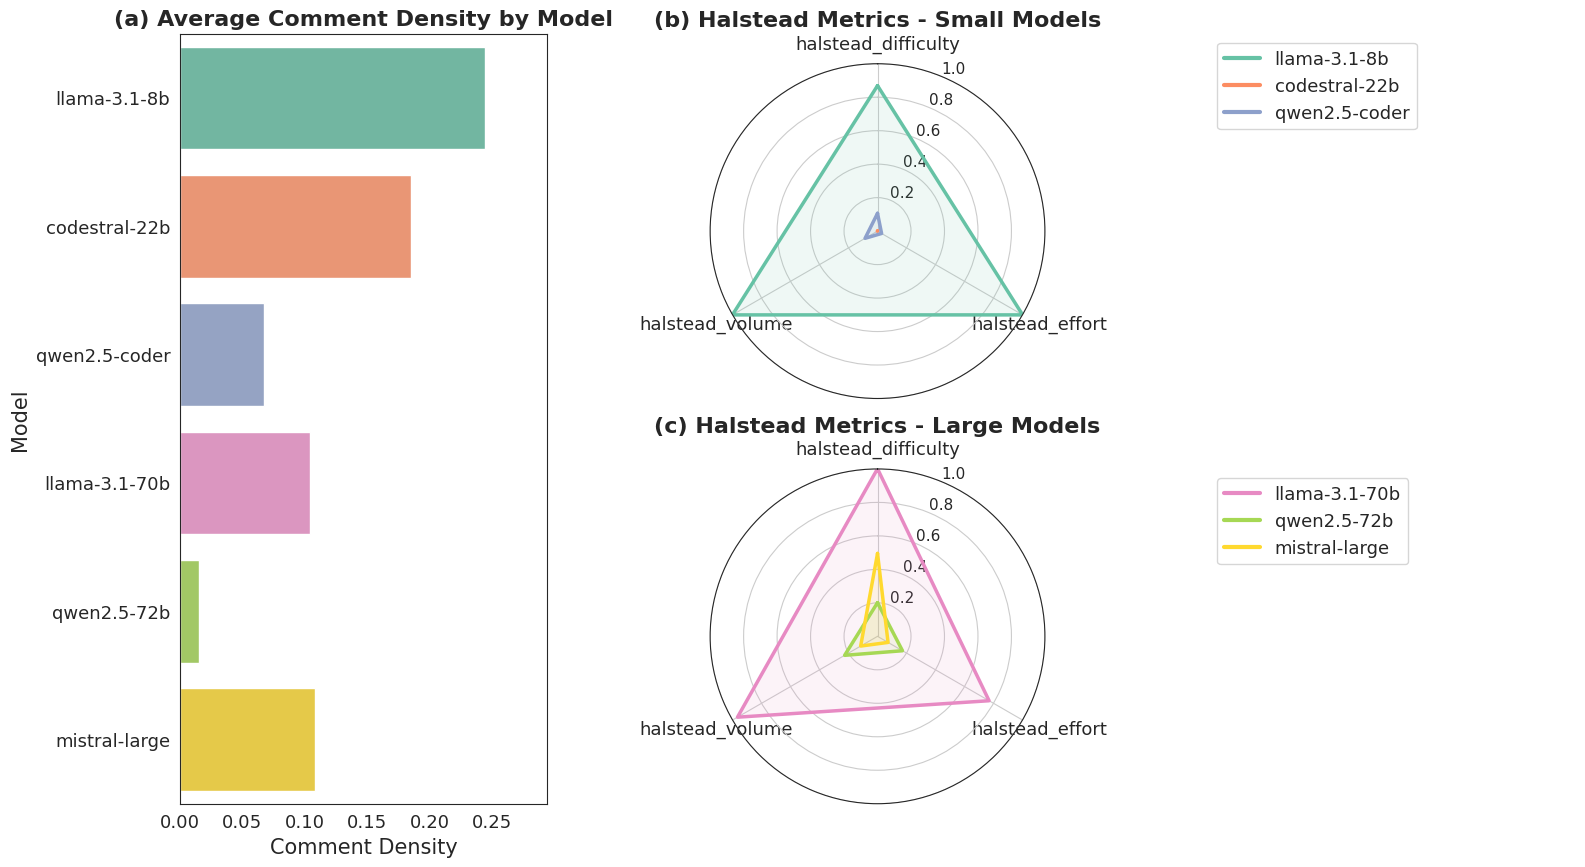

In [37]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
import pandas as pd

shared_palette = sns.color_palette("Set2", n_colors=len(custom_order))
model_color_map = dict(zip(custom_order, map(to_hex, shared_palette)))

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1], hspace=0.3, wspace=0.4)

ax_bar = fig.add_subplot(gs[:, 0])
sns.barplot(
    y=comment_summary.index,
    x=comment_summary.values,
    palette=[model_color_map[m] for m in comment_summary.index],
    orient='h',
    ax=ax_bar
)
ax_bar.set_xlabel("Comment Density", fontsize=15)
ax_bar.set_ylabel("Model", fontsize=15)
ax_bar.set_xlim(0, max(comment_summary.values.max(), 0.2) + 0.05)
ax_bar.set_title("(a) Average Comment Density by Model", fontsize=16, fontweight="bold")
ax_bar.tick_params(axis='both', labelsize=13)

for i, group in enumerate(model_groups):
    ax_radar = fig.add_subplot(gs[i, 1], polar=True)
    group_models = [m for m in group if m in halstead_normalized.index]

    for model in group_models:
        values = halstead_normalized.loc[model].tolist()
        values += values[:1]
        color = model_color_map.get(model, "#999999")
        ax_radar.plot(angles, values, label=model, linewidth=2.5, color=color)
        ax_radar.fill(angles, values, alpha=0.1, color=color)

    ax_radar.set_theta_offset(np.pi / 2)
    ax_radar.set_theta_direction(-1)
    ax_radar.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=13)
    ax_radar.set_ylim(0, 1)
    ax_radar.yaxis.set_tick_params(labelsize=11)
    ax_radar.set_title(
        "(b) Halstead Metrics - Small Models" if i == 0 else "(c) Halstead Metrics - Large Models",
        fontsize=16,
        fontweight="bold"
    )

    if i == 0:
        pos = ax_radar.get_position()
        ax_radar.set_position([pos.x0, pos.y0 - 0.03, pos.width, pos.height])

    ax_legend = fig.add_subplot(gs[i, 2])
    ax_legend.axis("off")

    legend_handles = [Line2D([0], [0], color=model_color_map[m], lw=3) for m in group_models]
    ax_legend.legend(
        legend_handles,
        group_models,
        loc='upper left',
        fontsize=13,
        frameon=True,
    )

plt.tight_layout()
#plt.savefig("Images/Slide_CommentDensity_HalsteadRadar.png", dpi=600, bbox_inches='tight')
plt.show()

In [38]:
import pandas as pd

comment_density_df = pd.DataFrame({
    "Model": comment_summary.index,
    "Comment Density (comments / LOC)": comment_summary.values.round(3)
})

print("Average Comment Density by Model:")
display(comment_density_df)

for i, group in enumerate(model_groups):
    print(f"\nHalstead Metrics for {'Small Models' if i == 0 else 'Large Models'}:")
    halstead_sub_df = halstead_normalized.loc[group].round(3)
    display(halstead_sub_df)

Average Comment Density by Model:


,Model,Comment Density (comments / LOC)
0,llama-3.1-8b,0.244
1,codestral-22b,0.185
2,qwen2.5-coder,0.067
3,llama-3.1-70b,0.104
4,qwen2.5-72b,0.015
5,mistral-large,0.108



Halstead Metrics for Small Models:


,halstead_difficulty,halstead_effort,halstead_volume
Model,,,
llama-3.1-8b,0.869,1.001,1.001
codestral-22b,0.001,0.001,0.001
qwen2.5-coder,0.106,0.028,0.086



Halstead Metrics for Large Models:


,halstead_difficulty,halstead_effort,halstead_volume
Model,,,
llama-3.1-70b,1.001,0.769,0.966
qwen2.5-72b,0.201,0.172,0.227
mistral-large,0.495,0.073,0.116


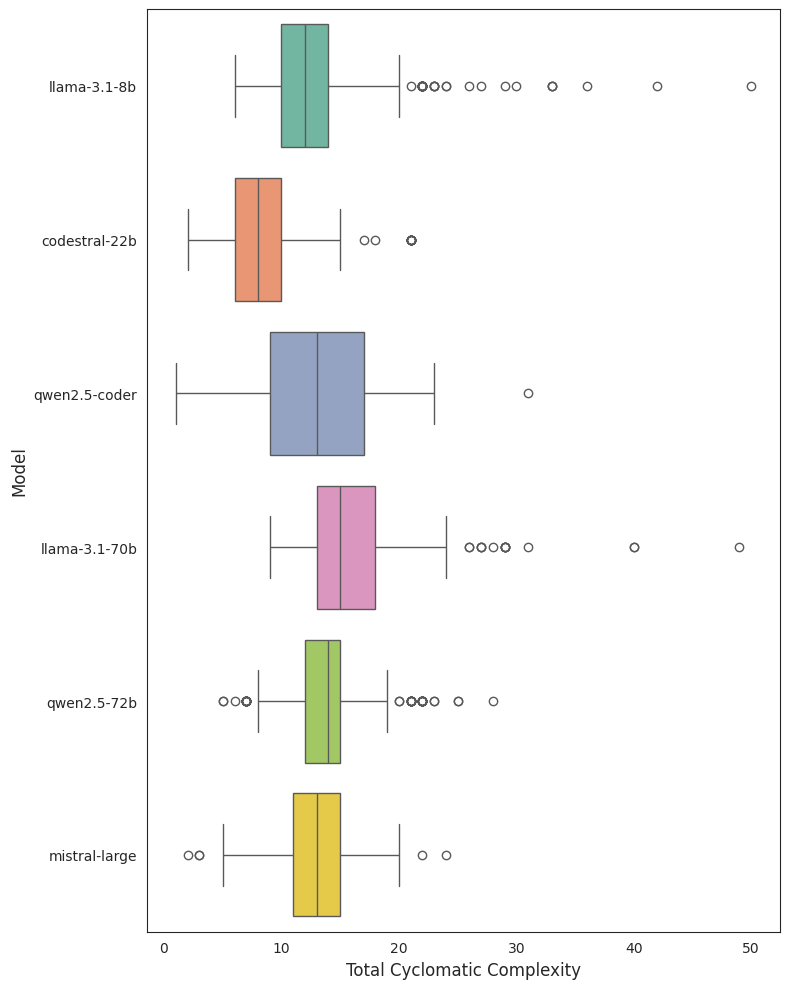

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

all_code_dfs = []

for path in experiment_dirs:
    df_code = pd.read_csv(f"{path}/code_evaluation_log.csv")
    df_code["Model"] = df_code["Model"].map(model_labels)
    all_code_dfs.append(df_code)

df_code_all = pd.concat(all_code_dfs, ignore_index=True)

plt.figure(figsize=(8, 10))
sns.boxplot(
    data=df_code_all,
    x="total_cyclomatic_complexity",
    y="Model",
    palette="Set2",
    order=custom_order
)

plt.xlabel("Total Cyclomatic Complexity", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.tight_layout()
plt.show()

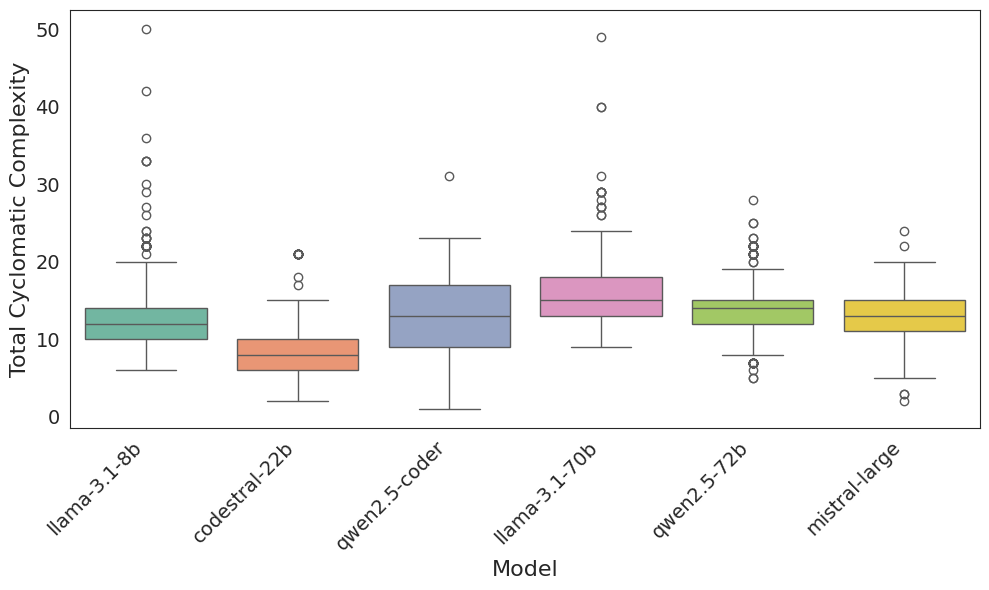

In [39]:
all_code_dfs = []

for path in experiment_dirs:
    df_code = pd.read_csv(f"{path}/code_evaluation_log.csv")
    df_code["Model"] = df_code["Model"].map(model_labels)
    all_code_dfs.append(df_code)

df_code_all = pd.concat(all_code_dfs, ignore_index=True)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_code_all,
    y="total_cyclomatic_complexity",
    x="Model",
    palette="Set2",
    order=custom_order
)

plt.ylabel("Total Cyclomatic Complexity", fontsize=16)
plt.xlabel("Model", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig("Images/Cyclomatic Complexity Distribution per Model.png", dpi=600, bbox_inches='tight')
plt.show()

In [18]:
import pandas as pd

summary_stats = df_code_all.groupby("Model")["total_cyclomatic_complexity"].describe()

summary_table = summary_stats[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]].rename(columns={
    "count": "Count",
    "mean": "Mean",
    "std": "Std Dev",
    "min": "Min",
    "25%": "25th Percentile",
    "50%": "Median",
    "75%": "75th Percentile",
    "max": "Max"
})

summary_table = summary_table.round(2)

print("Summary statistics for Total Cyclomatic Complexity per Model:")
display(summary_table)

Summary statistics for Total Cyclomatic Complexity per Model:


,Count,Mean,Std Dev,Min,25th Percentile,Median,75th Percentile,Max
Model,,,,,,,,
codestral-22b,317.0,8.08,3.83,2.0,6.0,8.0,10.0,21.0
llama-3.1-70b,387.0,16.14,4.47,9.0,13.0,15.0,18.0,49.0
llama-3.1-8b,420.0,12.86,5.25,6.0,10.0,12.0,14.0,50.0
mistral-large,312.0,12.75,3.18,2.0,11.0,13.0,15.0,24.0
qwen2.5-72b,349.0,13.87,3.92,5.0,12.0,14.0,15.0,28.0
qwen2.5-coder,326.0,12.48,5.05,1.0,9.0,13.0,17.0,31.0


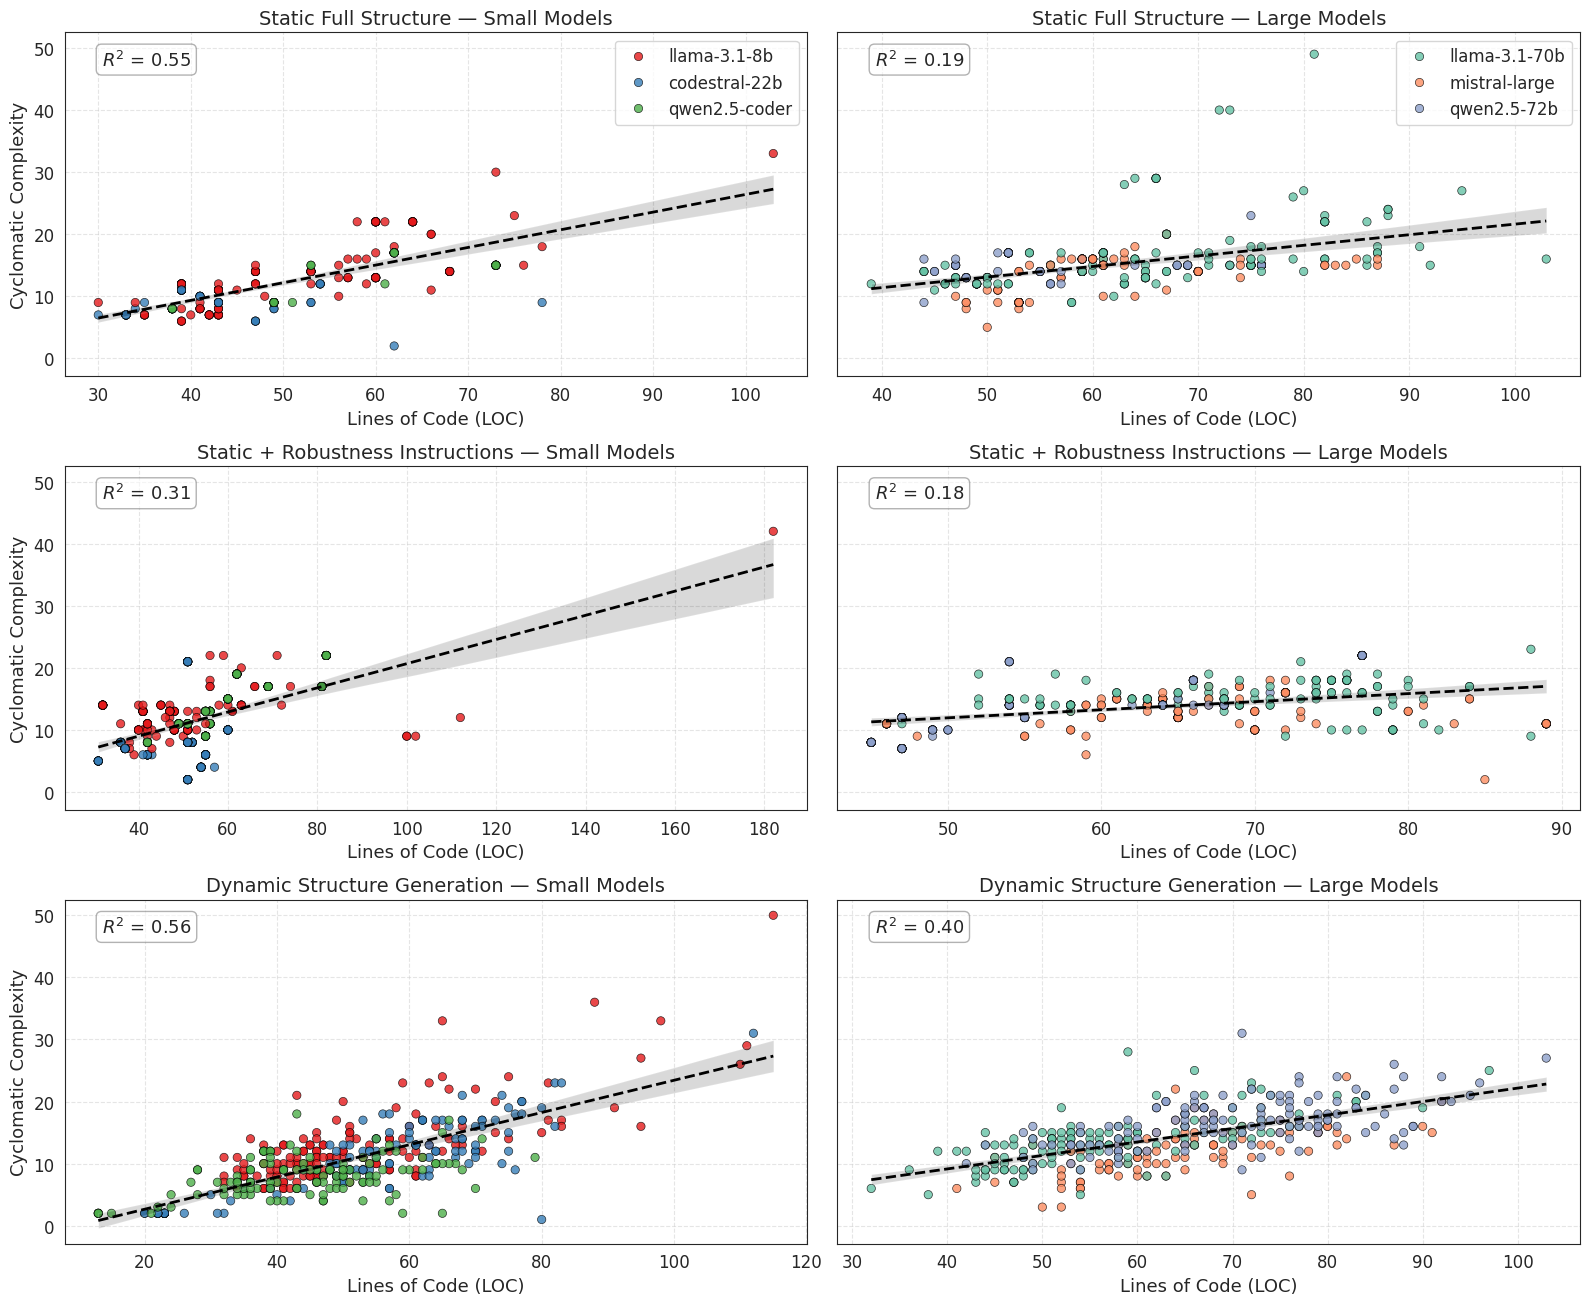

In [9]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import to_hex

shared_palette = sns.color_palette("Set2", n_colors=len(custom_order))
model_color_map = dict(zip(custom_order, map(to_hex, shared_palette)))

all_code_dfs = []
for path in experiment_dirs:
    df_code = pd.read_csv(f"{path}/code_evaluation_log.csv")
    df_code["Experiment"] = path
    df_code["Model"] = df_code["Model"].map(model_labels)
    all_code_dfs.append(df_code)

df_code_all = pd.concat(all_code_dfs, ignore_index=True)

fig, axes = plt.subplots(3, 2, figsize=(16, 14), sharey=True)

def annotate_r2(df, ax):
    if len(df) >= 2:
        x = df["raw_loc"].values.reshape(-1, 1)
        y = df["total_cyclomatic_complexity"].values
        model = LinearRegression().fit(x, y)
        r2 = model.score(x, y)
        ax.text(
            0.05, 0.95,
            f"$R^2$ = {r2:.2f}",
            transform=ax.transAxes,
            fontsize=13, 
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.6)
        )

for row_idx, (exp_dir, exp_title) in enumerate(zip(experiment_dirs, experiment_titles)):
    df_exp = df_code_all[df_code_all["Experiment"] == exp_dir]
    
    # Small models
    df_small = df_exp[df_exp["Model"].isin(small_models)]
    ax_small = axes[row_idx, 0]
    sns.scatterplot(
        data=df_small,
        x="raw_loc",
        y="total_cyclomatic_complexity",
        hue="Model",
        palette="Set1",
        ax=ax_small,
        alpha=0.8,
        edgecolor="black"
    )
    sns.regplot(
        data=df_small,
        x="raw_loc",
        y="total_cyclomatic_complexity",
        scatter=False,
        ax=ax_small,
        color="black",
        line_kws={"linewidth": 2, "linestyle": "--"}
    )
    annotate_r2(df_small, ax_small)
    ax_small.set_title(f"{exp_title} — Small Models", fontsize=14)
    ax_small.set_xlabel("Lines of Code (LOC)", fontsize=13)
    ax_small.set_ylabel("Cyclomatic Complexity", fontsize=13)
    ax_small.tick_params(axis='both', labelsize=12)
    ax_small.grid(True, linestyle="--", alpha=0.5)
    if row_idx != 0:
        ax_small.legend().remove()
    else:
        ax_small.legend(fontsize=12)       
    
    df_large = df_exp[df_exp["Model"].isin(large_models)]
    ax_large = axes[row_idx, 1]
    sns.scatterplot(
        data=df_large,
        x="raw_loc",
        y="total_cyclomatic_complexity",
        hue="Model",
        palette="Set2",
        ax=ax_large,
        alpha=0.8,
        edgecolor="black"
    )
    sns.regplot(
        data=df_large,
        x="raw_loc",
        y="total_cyclomatic_complexity",
        scatter=False,
        ax=ax_large,
        color="black",
        line_kws={"linewidth": 2, "linestyle": "--"}
    )
    annotate_r2(df_large, ax_large)
    ax_large.set_title(f"{exp_title} — Large Models", fontsize=14)
    ax_large.set_xlabel("Lines of Code (LOC)", fontsize=13)
    ax_large.set_ylabel("", fontsize=13)
    ax_large.tick_params(axis='both', labelsize=12)
    ax_large.grid(True, linestyle="--", alpha=0.5)
    if row_idx != 0:
        ax_large.legend().remove()
    else:
        ax_large.legend(fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
#plt.savefig("Images/Cyc-LOC.png", dpi=600, bbox_inches='tight') 
plt.show()

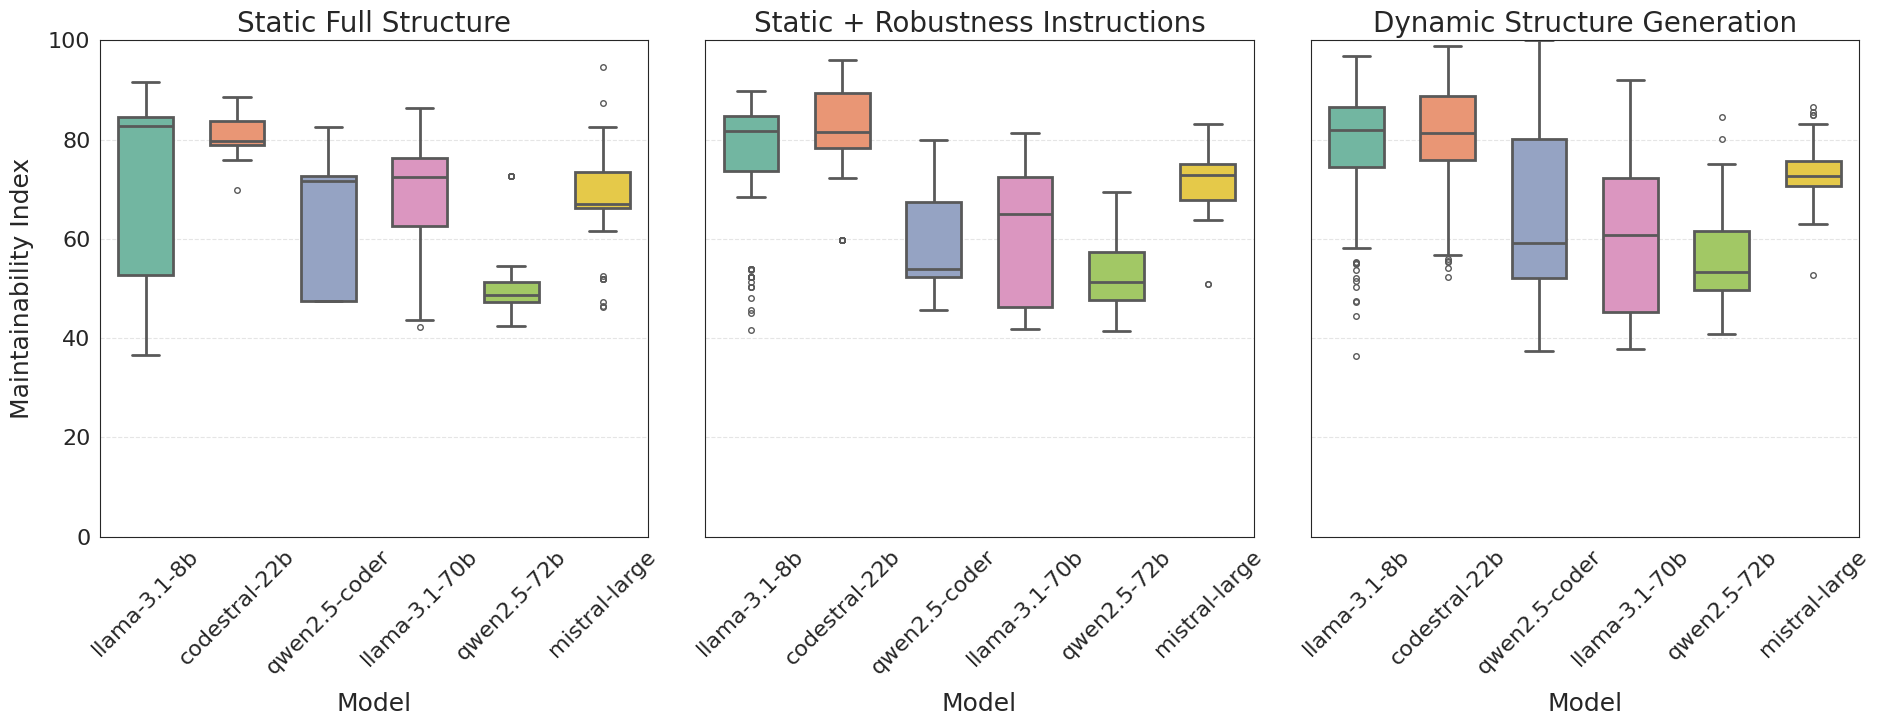

In [48]:
from matplotlib.colors import to_hex
all_data = []

shared_palette = sns.color_palette("Set2", n_colors=len(custom_order))
model_color_map = dict(zip(custom_order, map(to_hex, shared_palette)))

for label, path in zip(experiment_titles, experiment_dirs):
    df_perf = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df_perf = df_perf[df_perf["No Data"] == False]
    df_perf["F1"] = pd.to_numeric(df_perf["F1"], errors='coerce')
    df_perf["Model"] = df_perf["Model"].map(model_labels)
    
    df_code = pd.read_csv(f"{path}/code_evaluation_log.csv", na_values=["", " "])
    df_code["maintainability_index"] = pd.to_numeric(df_code["maintainability_index"], errors='coerce')
    df_code["Model"] = df_code["Model"].map(model_labels)

    
    df_merged = pd.merge(
        df_perf, df_code,
        on="Experiment ID",
        how="inner",
        suffixes=("_perf", "_code")
    )

    df_merged["Model"] = df_merged["Model_perf"]
    
    df_merged["Experiment"] = label
    all_data.append(df_merged)

df_all = pd.concat(all_data, ignore_index=True)

df_all["Model"] = pd.Categorical(df_all["Model"], categories=custom_order, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(19, 8), sharey=True)

for i, experiment in enumerate(experiment_titles):
    ax = axes[i]
    subset = df_all[df_all["Experiment"] == experiment]

    sns.boxplot(
        data=subset,
        x="Model",
        y="maintainability_index",
        ax=ax,
        palette=model_color_map,
        linewidth=2,
        fliersize=4,
        width=0.6
    )

    ax.set_title(experiment, fontsize=20)
    ax.set_xlabel("Model", fontsize=18, labelpad=10)
    ax.set_ylabel("Maintainability Index" if i == 0 else "", fontsize=18, labelpad=10)

    ax.tick_params(axis='x', labelsize=16, rotation=45)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_ylim(0, 100)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig("Images/Maintainability Index per Model.png", dpi=600, bbox_inches='tight') 
plt.show()

In [49]:
import pandas as pd

for experiment in experiment_titles:
    subset = df_all[df_all["Experiment"] == experiment]
    summary_stats = subset.groupby("Model")["maintainability_index"].describe()
    
    summary_table = summary_stats[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]].rename(columns={
        "count": "Count",
        "mean": "Mean",
        "std": "Std Dev",
        "min": "Min",
        "25%": "25th Percentile",
        "50%": "Median",
        "75%": "75th Percentile",
        "max": "Max"
    }).round(2)
    
    print(f"Summary statistics for Maintainability Index - {experiment}:")
    display(summary_table)
    print("\n" + "="*80 + "\n")

Summary statistics for Maintainability Index - Static Full Structure:


,Count,Mean,Std Dev,Min,25th Percentile,Median,75th Percentile,Max
Model,,,,,,,,
llama-3.1-8b,109.0,72.97,16.61,36.59,52.81,82.68,84.60,91.55
codestral-22b,52.0,80.86,4.07,69.80,79.00,79.82,83.74,88.63
qwen2.5-coder,40.0,63.69,14.25,47.57,47.57,71.64,72.58,82.49
llama-3.1-70b,110.0,69.40,10.74,42.19,62.65,72.51,76.20,86.39
qwen2.5-72b,66.0,51.22,7.68,42.40,47.24,48.77,51.37,72.59
mistral-large,76.0,68.37,8.39,46.33,66.18,66.98,73.37,94.57




Summary statistics for Maintainability Index - Static + Robustness Instructions:


,Count,Mean,Std Dev,Min,25th Percentile,Median,75th Percentile,Max
Model,,,,,,,,
llama-3.1-8b,103.0,75.46,13.67,41.69,73.57,81.70,84.67,89.78
codestral-22b,107.0,81.58,10.26,59.70,78.23,81.45,89.39,96.05
qwen2.5-coder,125.0,58.99,10.76,45.70,52.32,53.84,67.35,79.92
llama-3.1-70b,95.0,61.63,12.48,41.75,46.23,65.03,72.56,81.38
qwen2.5-72b,110.0,52.67,7.50,41.46,47.70,51.27,57.30,69.39
mistral-large,99.0,71.52,5.44,50.84,67.82,72.77,75.09,83.11




Summary statistics for Maintainability Index - Dynamic Structure Generation:


,Count,Mean,Std Dev,Min,25th Percentile,Median,75th Percentile,Max
Model,,,,,,,,
llama-3.1-8b,121.0,78.34,12.02,36.32,74.39,81.84,86.51,96.88
codestral-22b,98.0,80.07,11.50,52.40,75.95,81.34,88.75,98.91
qwen2.5-coder,95.0,66.73,18.00,37.41,52.14,59.23,80.13,100.00
llama-3.1-70b,107.0,60.51,13.45,37.71,45.36,60.78,72.25,91.94
qwen2.5-72b,110.0,55.48,8.85,40.74,49.68,53.34,61.67,84.47
mistral-large,77.0,73.16,5.61,52.65,70.64,72.73,75.72,86.57
